In [ ]:
# This is the start of the notebook

## Execution of spelfig over a MAGPI spectrum

In this notebook we are going to execute my code spelfig over a magpi spectrum. This is a single spectrum integrated from the central brightest pixel of the IFS field of the target to a one effective radius (R50). Our goals:

* Achieve a correct execution.
* Measure effectively the time of execution and if possible try to minimize it
* Create a function to iterate fits between different models
* Translate to a script the process in this notebook to generalize it




We locate ourselves in the directory in which the code and the spectra files are. The 2 next cell is a bash command (must not contain python syntax)

In [1]:
!pip install emcee

In [2]:
# We begin the procedure. We have to install emcee in the first place:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits

# Import Spelfig packages:
import spl_fitters as spf
# import spl_setup as sps
import sps_setupv6 as sps

In [3]:
# Function to properly extract the MAGPI spectra:
def open_magpi_ppxf(file):
    smooth_sigma = 0.4 # To smooth the data with a gaussian kernel.
    flyspec = fits.open(file)
    flyspec = flyspec[1].data

    wave = flyspec['wavelength']
    gas_flux = flyspec['lines flux']
    err_flux = flyspec['flux error']

    spec = np.array([wave, gas_flux, err_flux]).T
    # spec = gaussian_filter1d(spec, smooth_sigma, axis=0)

    return spec

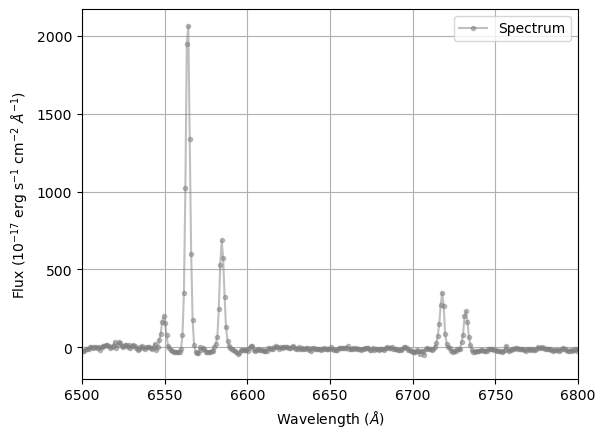

In [4]:
# We open the spectrum and visualize it:
file = '/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/magpi2304104201_aperture_1.25R50_ppxf.fits'
spec0 = open_magpi_ppxf(file)

# Define the spectrum
spectrum = spec0[:, 1]

plt.figure()
plt.plot(spec0[:, 0], spec0[:, 1], color='grey', marker='.', linestyle='-', label='Spectrum',
		 alpha=0.5)
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Flux ($10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
# plt.xlim(4800, 5010)
plt.xlim(6500, 6800)
# plt.ylim(-500, 500)
plt.grid('False')
plt.legend()
plt.show()


In [5]:
# We constrain the spectral range to be fitted:
specrange = (4800, 6800)

### MAGPI

In [6]:
# LINES DICTIONARIES:
# For reminding:
# Broad Line Region Lines (FOR AGNs):
# 'He-II,1', 'He-II,2', 'H-ζ', 'H-ε', 'H-δ', 'H-γ', 'H-β', 'He-I', 'H-α'
# Narrow Line Region:
# 	'O-III,1', 'O-III,2', 'N-II,1', 'N-II,2', 'S-II,1', 'S-II,2'

emission_line_models = {
	'He-II,1': {'wavelength':[3202.15], 'components': ['Voigt', 'Voigt']},
	'He-II,2': {'wavelength':[4685.74], 'components': ['Voigt', 'Voigt']},
	'Ne-V,1':  {'wavelength':[3345.81], 'components': ['Voigt']},
	'Ne-V,2':  {'wavelength':[3425.81], 'components': ['Voigt']},
	'O-II,1':  {'wavelength':[3726.03], 'components': ['Voigt']},
	'O-II,2':  {'wavelength':[3728.73], 'components': ['Voigt']},
	'Ne-III,1': {'wavelength':[3868.69], 'components': ['Voigt']},
	'Ne-III,2': {'wavelength':[3967.40], 'components': ['Voigt']},
	'H-ζ':    {'wavelength':[3889.05], 'components': ['Voigt', 'Voigt']},
	'H-ε':    {'wavelength':[3970.07], 'components': ['Voigt', 'Voigt']},
	'H-δ':    {'wavelength':[4101.73], 'components': ['Voigt', 'Voigt']},
	'H-γ':    {'wavelength':[4340.46], 'components': ['Voigt', 'Voigt']},
	'O-III,0':  {'wavelength':[4363.15], 'components': ['Voigt']},
	'O-III,1':  {'wavelength':[4958.83], 'components': ['Voigt', 'Voigt']},
	'O-III,2':  {'wavelength':[5006.77], 'components': ['Voigt', 'Voigt']},
	'Ar-IV,1':  {'wavelength':[4711.30], 'components': ['Voigt']},
	'Ar-IV,2':  {'wavelength':[4740.10], 'components': ['Voigt']},
	'H-β':     {'wavelength':[4861.32], 'components': ['Voigt', 'Voigt']},
	'N-I,1':    {'wavelength':[5197.90], 'components': ['Voigt']},
	'N-I,2':    {'wavelength':[5200.39], 'components': ['Voigt']},
	'He-I':   {'wavelength':[5875.60], 'components': ['Voigt']},
	'O-I,1':   {'wavelength':[6300.20], 'components': ['Voigt']},
	'O-I,2':   {'wavelength':[6363.67], 'components': ['Voigt']},
	'N-II,1':   {'wavelength':[6547.96], 'components': ['Voigt']},
	'N-II,2':   {'wavelength':[6583.34], 'components': ['Voigt']},
	'H-α':     {'wavelength':[6562.80], 'components': ['Voigt', 'Voigt']},
	'S-II,1':  {'wavelength': [6716.31], 'components': ['Voigt', 'Voigt']},
	'S-II,2':   {'wavelength':[6730.68], 'components': ['Voigt', 'Voigt']},
	'Ar-III': {'wavelength':[7135.67], 'components': ['Voigt']},
	}

# emission_line_models = {
# 	'He-II,1': {'wavelength':[3202.15], 'components': ['Lorentzian', 'Lorentzian']},
# 	'He-II,2': {'wavelength':[4685.74], 'components': ['Lorentzian', 'Lorentzian']},
# 	'Ne-V,1':  {'wavelength':[3345.81], 'components': ['Lorentzian']},
# 	'Ne-V,2':  {'wavelength':[3425.81], 'components': ['Lorentzian']},
# 	'O-II,1':  {'wavelength':[3726.03], 'components': ['Lorentzian']},
# 	'O-II,2':  {'wavelength':[3728.73], 'components': ['Lorentzian']},
# 	'Ne-III,1': {'wavelength':[3868.69], 'components': ['Lorentzian']},
# 	'Ne-III,2': {'wavelength':[3967.40], 'components': ['Lorentzian']},
# 	'H-ζ':    {'wavelength':[3889.05], 'components': ['Lorentzian', 'Lorentzian']},
# 	'H-ε':    {'wavelength':[3970.07], 'components': ['Lorentzian', 'Lorentzian']},
# 	'H-δ':    {'wavelength':[4101.73], 'components': ['Lorentzian', 'Lorentzian']},
# 	'H-γ':    {'wavelength':[4340.46], 'components': ['Lorentzian', 'Lorentzian']},
# 	'O-III,0':  {'wavelength':[4363.15], 'components': ['Lorentzian']},
# 	'O-III,1':  {'wavelength':[4958.83], 'components': ['Lorentzian', 'Lorentzian']},
# 	'O-III,2':  {'wavelength':[5006.77], 'components': ['Lorentzian', 'Lorentzian']},
# 	'Ar-IV,1':  {'wavelength':[4711.30], 'components': ['Lorentzian']},
# 	'Ar-IV,2':  {'wavelength':[4740.10], 'components': ['Lorentzian']},
# 	'H-β':     {'wavelength':[4861.32], 'components': ['Lorentzian', 'Lorentzian']},
# 	'N-I,1':    {'wavelength':[5197.90], 'components': ['Lorentzian']},
# 	'N-I,2':    {'wavelength':[5200.39], 'components': ['Lorentzian']},
# 	'He-I':   {'wavelength':[5875.60], 'components': ['Lorentzian']},
# 	'O-I,1':   {'wavelength':[6300.20], 'components': ['Lorentzian']},
# 	'O-I,2':   {'wavelength':[6363.67], 'components': ['Lorentzian']},
# 	'N-II,1':   {'wavelength':[6547.96], 'components': ['Lorentzian']},
# 	'N-II,2':   {'wavelength':[6583.34], 'components': ['Lorentzian']},
# 	'H-α':     {'wavelength':[6562.80], 'components': ['Lorentzian', 'Lorentzian']},
# 	'S-II,1':  {'wavelength': [6716.31], 'components': ['Lorentzian', 'Lorentzian']},
# 	'S-II,2':   {'wavelength':[6730.68], 'components': ['Lorentzian', 'Lorentzian']},
# 	'Ar-III': {'wavelength':[7135.67], 'components': ['Lorentzian']},
# 	}

# emission_line_models = {
# 	'He-II,1': {'wavelength':[3202.15], 'components': ['Gaussian', 'Gaussian']},
# 	'He-II,2': {'wavelength':[4685.74], 'components': ['Gaussian', 'Gaussian']},
# 	'Ne-V,1':  {'wavelength':[3345.81], 'components': ['Gaussian']},
# 	'Ne-V,2':  {'wavelength':[3425.81], 'components': ['Gaussian']},
# 	'O-II,1':  {'wavelength':[3726.03], 'components': ['Gaussian']},
# 	'O-II,2':  {'wavelength':[3728.73], 'components': ['Gaussian']},
# 	'Ne-III,1': {'wavelength':[3868.69], 'components': ['Gaussian']},
# 	'Ne-III,2': {'wavelength':[3967.40], 'components': ['Gaussian']},
# 	'H-ζ':    {'wavelength':[3889.05], 'components': ['Gaussian', 'Gaussian']},
# 	'H-ε':    {'wavelength':[3970.07], 'components': ['Gaussian', 'Gaussian']},
# 	'H-δ':    {'wavelength':[4101.73], 'components': ['Gaussian', 'Gaussian']},
# 	'H-γ':    {'wavelength':[4340.46], 'components': ['Gaussian', 'Gaussian']},
# 	'O-III,0':  {'wavelength':[4363.15], 'components': ['Gaussian']},
# 	'O-III,1':  {'wavelength':[4958.83], 'components': ['Gaussian', 'Gaussian']},
# 	'O-III,2':  {'wavelength':[5006.77], 'components': ['Gaussian', 'Gaussian']},
# 	'Ar-IV,1':  {'wavelength':[4711.30], 'components': ['Gaussian']},
# 	'Ar-IV,2':  {'wavelength':[4740.10], 'components': ['Gaussian']},
# 	'H-β':     {'wavelength':[4861.32], 'components': ['Gaussian', 'Gaussian']},
# 	'N-I,1':    {'wavelength':[5197.90], 'components': ['Gaussian']},
# 	'N-I,2':    {'wavelength':[5200.39], 'components': ['Gaussian']},
# 	'He-I':   {'wavelength':[5875.60], 'components': ['Gaussian']},
# 	'O-I,1':   {'wavelength':[6300.20], 'components': ['Gaussian']},
# 	'O-I,2':   {'wavelength':[6363.67], 'components': ['Gaussian']},
# 	'N-II,1':   {'wavelength':[6547.96], 'components': ['Gaussian']},
# 	'N-II,2':   {'wavelength':[6583.34], 'components': ['Gaussian']},
# 	'H-α':     {'wavelength':[6562.80], 'components': ['Gaussian', 'Gaussian']},
# 	'S-II,1':  {'wavelength': [6716.31], 'components': ['Gaussian', 'Gaussian']},
# 	'S-II,2':   {'wavelength':[6730.68], 'components': ['Gaussian', 'Gaussian']},
# 	'Ar-III': {'wavelength':[7135.67], 'components': ['Gaussian']},
# 	}

Create the first estimations

Complete data


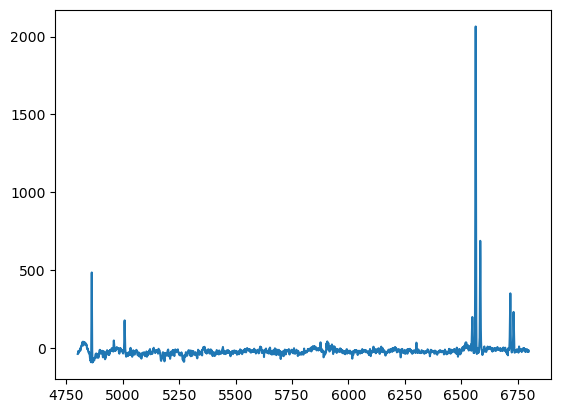

LETS REVIEW THE FIRST ANALYZING OF THE EMISSION LINES
This first reference wavelength 3202.15
This first reference wavelength 4685.74
This first reference wavelength 3345.81
This first reference wavelength 3425.81
This first reference wavelength 3726.03
This first reference wavelength 3728.73
This first reference wavelength 3868.69
This first reference wavelength 3967.4
This first reference wavelength 3889.05
This first reference wavelength 3970.07
This first reference wavelength 4101.73
This first reference wavelength 4340.46
This first reference wavelength 4363.15
This first reference wavelength 4958.83
len window_wavelengths 61
This is the maximum flux inside the window 46.339454616539854
This first reference wavelength 5006.77
len window_wavelengths 60
This is the maximum flux inside the window 175.55185729813223
This first reference wavelength 4711.3
This first reference wavelength 4740.1
This first reference wavelength 4861.32
len window_wavelengths 62
This is the maximum flux in

/Users/aksitadeo/PycharmProjects/spelfig_aksita/spl_models.py:26: RuntimeWarning: invalid value encountered in power
  return a*(x/b)**(-c)


UnboundLocalError: cannot access local variable 'params_i' where it is not associated with a value

In [7]:
## Initial assumptions for the continuum
initial_conditions = {
    "powerlaw function": {"gamma": -0.01}
}

## Spectral index for the continuum:
gamma0 = -0.01

## Observed data stored in variables:

try:
    df0 = sps.init_setup(spec0, emission_line_models, specrange, gamma0);
except RuntimeWarning:
    print("Error occurred during setup. Skipping...")
    df0 = np.empty(0)

df0

In [8]:
# Lets visualize the initial estimations:
# plot0 = sps.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], df0, x_zoom=(6500, 6800))

In [9]:
# Time to run the emcee fits:
fit0,_ = spf.run_mcmc_chains(df0, spec0[:, 0], spec0[:, 1], spec0[:, 0], niter=5000)
fit0

NameError: name 'df0' is not defined

In [10]:
# Plot the initial estimation against the converged values
plot0 = sps.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], fit0, x_zoom=(6500, 6800)) #, x_zoom=(4800, 5050))
# plot1 = sps.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], df0, x_zoom=(6500, 6800)) #, x_zoom=(4800, 5050))

NameError: name 'fit0' is not defined

In [11]:
# LINES DICTIONARIES:
# For reminding:
# Broad Line Region Lines (FOR AGNs):
# 'He-II,1', 'He-II,2', 'H-ζ', 'H-ε', 'H-δ', 'H-γ', 'H-β', 'He-I', 'H-α'
# Narrow Line Region:
# 	'O-III,1', 'O-III,2', 'N-II,1', 'N-II,2', 'S-II,1', 'S-II,2'

# emission_line_models = {
# 	'He-II,1': {'wavelength':[3202.15], 'components': ['Voigt', 'Voigt']},
# 	'He-II,2': {'wavelength':[4685.74], 'components': ['Voigt', 'Voigt']},
# 	'Ne-V,1':  {'wavelength':[3345.81], 'components': ['Voigt']},
# 	'Ne-V,2':  {'wavelength':[3425.81], 'components': ['Voigt']},
# 	'O-II,1':  {'wavelength':[3726.03], 'components': ['Voigt']},
# 	'O-II,2':  {'wavelength':[3728.73], 'components': ['Voigt']},
# 	'Ne-III,1': {'wavelength':[3868.69], 'components': ['Voigt']},
# 	'Ne-III,2': {'wavelength':[3967.40], 'components': ['Voigt']},
# 	'H-ζ':    {'wavelength':[3889.05], 'components': ['Voigt', 'Voigt']},
# 	'H-ε':    {'wavelength':[3970.07], 'components': ['Voigt', 'Voigt']},
# 	'H-δ':    {'wavelength':[4101.73], 'components': ['Voigt', 'Voigt']},
# 	'H-γ':    {'wavelength':[4340.46], 'components': ['Voigt', 'Voigt']},
# 	'O-III,0':  {'wavelength':[4363.15], 'components': ['Voigt']},
# 	'O-III,1':  {'wavelength':[4958.83], 'components': ['Voigt']},
# 	'O-III,2':  {'wavelength':[5006.77], 'components': ['Voigt']},
# 	'Ar-IV,1':  {'wavelength':[4711.30], 'components': ['Voigt']},
# 	'Ar-IV,2':  {'wavelength':[4740.10], 'components': ['Voigt']},
# 	'H-β':     {'wavelength':[4861.32], 'components': ['Voigt', 'Voigt']},
# 	'N-I,1':    {'wavelength':[5197.90], 'components': ['Voigt']},
# 	'N-I,2':    {'wavelength':[5200.39], 'components': ['Voigt']},
# 	'He-I':   {'wavelength':[5875.60], 'components': ['Voigt']},
# 	'O-I,1':   {'wavelength':[6300.20], 'components': ['Voigt']},
# 	'O-I,2':   {'wavelength':[6363.67], 'components': ['Voigt']},
# 	'N-II,1':   {'wavelength':[6547.96], 'components': ['Voigt']},
# 	'N-II,2':   {'wavelength':[6583.34], 'components': ['Voigt']},
# 	'H-α':     {'wavelength':[6562.80], 'components': ['Voigt']},
# 	'S-II,1':  {'wavelength': [6716.31], 'components': ['Voigt']},
# 	'S-II,2':   {'wavelength':[6730.68], 'components': ['Voigt']},
# 	'Ar-III': {'wavelength':[7135.67], 'components': ['Voigt']},
# 	}

emission_line_models = {
	'He-II,1': {'wavelength':[3202.15], 'components': ['Lorentzian', 'Lorentzian']},
	'He-II,2': {'wavelength':[4685.74], 'components': ['Lorentzian', 'Lorentzian']},
	'Ne-V,1':  {'wavelength':[3345.81], 'components': ['Lorentzian']},
	'Ne-V,2':  {'wavelength':[3425.81], 'components': ['Lorentzian']},
	'O-II,1':  {'wavelength':[3726.03], 'components': ['Lorentzian']},
	'O-II,2':  {'wavelength':[3728.73], 'components': ['Lorentzian']},
	'Ne-III,1': {'wavelength':[3868.69], 'components': ['Lorentzian']},
	'Ne-III,2': {'wavelength':[3967.40], 'components': ['Lorentzian']},
	'H-ζ':    {'wavelength':[3889.05], 'components': ['Lorentzian', 'Lorentzian']},
	'H-ε':    {'wavelength':[3970.07], 'components': ['Lorentzian', 'Lorentzian']},
	'H-δ':    {'wavelength':[4101.73], 'components': ['Lorentzian', 'Lorentzian']},
	'H-γ':    {'wavelength':[4340.46], 'components': ['Lorentzian', 'Lorentzian']},
	'O-III,0':  {'wavelength':[4363.15], 'components': ['Lorentzian']},
	'O-III,1':  {'wavelength':[4958.83], 'components': ['Lorentzian']},
	'O-III,2':  {'wavelength':[5006.77], 'components': ['Lorentzian']},
	'Ar-IV,1':  {'wavelength':[4711.30], 'components': ['Lorentzian']},
	'Ar-IV,2':  {'wavelength':[4740.10], 'components': ['Lorentzian']},
	'H-β':     {'wavelength':[4861.32], 'components': ['Lorentzian', 'Lorentzian']},
	'N-I,1':    {'wavelength':[5197.90], 'components': ['Lorentzian']},
	'N-I,2':    {'wavelength':[5200.39], 'components': ['Lorentzian']},
	'He-I':   {'wavelength':[5875.60], 'components': ['Lorentzian']},
	'O-I,1':   {'wavelength':[6300.20], 'components': ['Lorentzian']},
	'O-I,2':   {'wavelength':[6363.67], 'components': ['Lorentzian']},
	'N-II,1':   {'wavelength':[6547.96], 'components': ['Lorentzian']},
	'N-II,2':   {'wavelength':[6583.34], 'components': ['Lorentzian']},
	'H-α':     {'wavelength':[6562.80], 'components': ['Lorentzian']},
	'S-II,1':  {'wavelength': [6716.31], 'components': ['Lorentzian']},
	'S-II,2':   {'wavelength':[6730.68], 'components': ['Lorentzian']},
	'Ar-III': {'wavelength':[7135.67], 'components': ['Lorentzian']},
	}

# emission_line_models = {
# 	'He-II,1': {'wavelength':[3202.15], 'components': ['Gaussian', 'Gaussian']},
# 	'He-II,2': {'wavelength':[4685.74], 'components': ['Gaussian', 'Gaussian']},
# 	'Ne-V,1':  {'wavelength':[3345.81], 'components': ['Gaussian']},
# 	'Ne-V,2':  {'wavelength':[3425.81], 'components': ['Gaussian']},
# 	'O-II,1':  {'wavelength':[3726.03], 'components': ['Gaussian']},
# 	'O-II,2':  {'wavelength':[3728.73], 'components': ['Gaussian']},
# 	'Ne-III,1': {'wavelength':[3868.69], 'components': ['Gaussian']},
# 	'Ne-III,2': {'wavelength':[3967.40], 'components': ['Gaussian']},
# 	'H-ζ':    {'wavelength':[3889.05], 'components': ['Gaussian', 'Gaussian']},
# 	'H-ε':    {'wavelength':[3970.07], 'components': ['Gaussian', 'Gaussian']},
# 	'H-δ':    {'wavelength':[4101.73], 'components': ['Gaussian', 'Gaussian']},
# 	'H-γ':    {'wavelength':[4340.46], 'components': ['Gaussian', 'Gaussian']},
# 	'O-III,0':  {'wavelength':[4363.15], 'components': ['Gaussian']},
# 	'O-III,1':  {'wavelength':[4958.83], 'components': ['Gaussian']},
# 	'O-III,2':  {'wavelength':[5006.77], 'components': ['Gaussian']},
# 	'Ar-IV,1':  {'wavelength':[4711.30], 'components': ['Gaussian']},
# 	'Ar-IV,2':  {'wavelength':[4740.10], 'components': ['Gaussian']},
# 	'H-β':     {'wavelength':[4861.32], 'components': ['Gaussian']},
# 	'N-I,1':    {'wavelength':[5197.90], 'components': ['Gaussian']},
# 	'N-I,2':    {'wavelength':[5200.39], 'components': ['Gaussian']},
# 	'He-I':   {'wavelength':[5875.60], 'components': ['Gaussian']},
# 	'O-I,1':   {'wavelength':[6300.20], 'components': ['Gaussian']},
# 	'O-I,2':   {'wavelength':[6363.67], 'components': ['Gaussian']},
# 	'N-II,1':   {'wavelength':[6547.96], 'components': ['Gaussian']},
# 	'N-II,2':   {'wavelength':[6583.34], 'components': ['Gaussian']},
# 	'H-α':     {'wavelength':[6562.80], 'components': ['Gaussian']},
# 	'S-II,1':  {'wavelength': [6716.31], 'components': ['Gaussian']},
# 	'S-II,2':   {'wavelength':[6730.68], 'components': ['Gaussian']},
# 	'Ar-III': {'wavelength':[7135.67], 'components': ['Gaussian']},
# 	}

In [12]:
## Initial assumptions for the continuum
initial_conditions = {
    "powerlaw function": {"gamma": -0.01}
}

## Spectral index for the continuum:
gamma0 = -0.01

## Observed data stored in variables:
spec0 = super_dictionary['manga-9000-1901-0.5Reff.fits']['DATA']

try:
    df0 = sps.init_setup(spec0, emission_line_models, specrange, gamma0);
except RuntimeWarning:
    print("Error occurred during setup. Skipping...")
    df0 = np.empty(0)

df0

NameError: name 'super_dictionary' is not defined

In [13]:
fit0,_ = spf.run_mcmc_chains(df0, spec0[:, 0], spec0[:, 1], spec0[:, 0], niter=5000)
fit0
plot0 = sps.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], fit0 , x_zoom=(4800, 5050)) #, x_zoom=(6500, 6800)) #

NameError: name 'df0' is not defined

### Calculate velocity 

In [14]:
gaussdata = {
    'N-II,1': [[6549.39, 197.54, 1.51], [0.0099, 0.00090, 0.0010]],
    'H-α': [[6564.29, 1032.56, 1.29], [0.0010, 0.00096, 0.00086]],
    'N-II,2': [[6584.50, 687.03, 1.38], [0.0010, 0.00099, 0.00098]],
    'S-II,1': [[6717.87, 174.70, 1.35], [0.0010, 0.0011, 0.00096]],
    'S-II,2': [[6732.25, 114.96, 1.32], [0.0011, 0.0012, 0.00087]]
}

In [15]:
lorenzdata = {
    'N-II,1': [[6549.39, 197.54, 1.68], [0.0012, 0.00087, 0.00096]],
    'H-α': [[6564.29, 1032.56, 1.43], [0.00084, 0.0010, 0.0010]],
    'N-II,2': [[6584.50, 687.03, 1.54], [0.0011, 0.00091, 0.0010]],
    'S-II,1': [[6717.87, 174.70, 1.50], [0.00096, 0.00098, 0.0011]],
    'S-II,2': [[6732.25, 114.96, 1.47], [0.0012, 0.0011, 0.00087]]
}

In [16]:
voigtdata = {
    'N-II,1': [[6549.34, 197.54, 1.51], [0.0010, 0.00085, 0.0010]],
    'H-α': [[6564.29, 1032.56, 1.29], [0.00098, 0.0010, 0.00094]],
    'N-II,2': [[6584.50, 687.03, 1.39], [0.00082, 0.00097, 0.0010]],
    'S-II,1': [[6717.87, 174.69, 1.34], [0.00087, 0.0011, 0.00096]],
    'S-II,2': [[6732.25, 114.96, 1.32], [0.0010, 0.00090, 0.00089]]
}

In [17]:
c = 299792.458  # Speed of light in m/s
vels = []
err = []
distrib = []
derr = []

def calculate_velocity(observed_wavelength,rest_wvelength):
    return c * (observed_wavelength - rest_wvelength) / rest_wvelength

for line_name, line_data in lorenzdata.items():
    centroid, amplitude, distribution = line_data[0]
    centroid_error, amplitude_error, distribution_error = line_data[1]

    # Assuming rest_wavelength is known
    rest_wavelength = emission_line_models[line_name]['wavelength'][0]# Rest wavelength of the emission line

    velocity = calculate_velocity(centroid, rest_wavelength)
    velocity_error = calculate_velocity(centroid, rest_wavelength)*centroid_error # Calculate velocity error 
    vels.append(velocity)
    err.append(velocity_error)
    distrib.append(distribution)
    derr.append(distribution_error)
    
    print(f"{line_name}: Velocity = {velocity:.2f} km/s, Error = {velocity_error:.2f} km/s")
    
print(np.average(vels), '+-', np.average(err), 'km/s')
print(np.average(distrib), '+-', np.average(derr), 'km/s')

N-II,1: Velocity = 65.47 km/s, Error = 0.08 km/s
H-α: Velocity = 68.06 km/s, Error = 0.06 km/s
N-II,2: Velocity = 52.82 km/s, Error = 0.06 km/s
S-II,1: Velocity = 69.63 km/s, Error = 0.07 km/s
S-II,2: Velocity = 69.93 km/s, Error = 0.08 km/s
65.1844050767447 +- 0.06892181173849952 km/s
1.524 +- 0.0009860000000000001 km/s


### Components

In [19]:
emission_line_models_Gauss = {
	'He-II,1': {'wavelength':[3202.15], 'components': ['Gaussian']},
	'He-II,2': {'wavelength':[4685.74], 'components': ['Gaussian']},
	'Ne-V,1':  {'wavelength':[3345.81], 'components': ['Gaussian']},
	'Ne-V,2':  {'wavelength':[3425.81], 'components': ['Gaussian']},
	'O-II,1':  {'wavelength':[3726.03], 'components': ['Gaussian']},
	'O-II,2':  {'wavelength':[3728.73], 'components': ['Gaussian']},
	'Ne-III,1': {'wavelength':[3868.69], 'components': ['Gaussian']},
	'Ne-III,2': {'wavelength':[3967.40], 'components': ['Gaussian']},
	'H-ζ':    {'wavelength':[3889.05], 'components': ['Gaussian']},
	'H-ε':    {'wavelength':[3970.07], 'components': ['Gaussian']},
	'H-δ':    {'wavelength':[4101.73], 'components': ['Gaussian']},
	'H-γ':    {'wavelength':[4340.46], 'components': ['Gaussian']},
	'O-III,0':  {'wavelength':[4363.15], 'components': ['Gaussian']},
	'O-III,1':  {'wavelength':[4958.83], 'components': ['Gaussian']},
	'O-III,2':  {'wavelength':[5006.77], 'components': ['Gaussian']},
	'Ar-IV,1':  {'wavelength':[4711.30], 'components': ['Gaussian']},
	'Ar-IV,2':  {'wavelength':[4740.10], 'components': ['Gaussian']},
	'H-β':     {'wavelength':[4861.32], 'components': ['Gaussian']},
	'N-I,1':    {'wavelength':[5197.90], 'components': ['Gaussian']},
	'N-I,2':    {'wavelength':[5200.39], 'components': ['Gaussian']},
	'He-I':   {'wavelength':[5875.60], 'components': ['Gaussian']},
	'O-I,1':   {'wavelength':[6300.20], 'components': ['Gaussian']},
	'O-I,2':   {'wavelength':[6363.67], 'components': ['Gaussian']},
	'N-II,1':   {'wavelength':[6547.96], 'components': ['Gaussian']},
	'N-II,2':   {'wavelength':[6583.34], 'components': ['Gaussian']},
	'H-α':     {'wavelength':[6562.80], 'components': ['Gaussian']},
	'S-II,1':  {'wavelength': [6716.31], 'components': ['Gaussian']},
	'S-II,2':   {'wavelength':[6730.68], 'components': ['Gaussian']},
	'Ar-III': {'wavelength':[7135.67], 'components': ['Gaussian']},
	}

In [20]:
emission_line_models_twoGauss = {
	'He-II,1': {'wavelength':[3202.15], 'components': ['Gaussian','Gaussian']},
	'He-II,2': {'wavelength':[4685.74], 'components': ['Gaussian','Gaussian']},
	'Ne-V,1':  {'wavelength':[3345.81], 'components': ['Gaussian','Gaussian']},
	'Ne-V,2':  {'wavelength':[3425.81], 'components': ['Gaussian','Gaussian']},
	'O-II,1':  {'wavelength':[3726.03], 'components': ['Gaussian','Gaussian']},
	'O-II,2':  {'wavelength':[3728.73], 'components': ['Gaussian','Gaussian']},
	'Ne-III,1': {'wavelength':[3868.69], 'components': ['Gaussian','Gaussian']},
	'Ne-III,2': {'wavelength':[3967.40], 'components': ['Gaussian','Gaussian']},
	'H-ζ':    {'wavelength':[3889.05], 'components': ['Gaussian','Gaussian']},
	'H-ε':    {'wavelength':[3970.07], 'components': ['Gaussian','Gaussian']},
	'H-δ':    {'wavelength':[4101.73], 'components': ['Gaussian','Gaussian']},
	'H-γ':    {'wavelength':[4340.46], 'components': ['Gaussian','Gaussian']},
	'O-III,0':  {'wavelength':[4363.15], 'components': ['Gaussian','Gaussian']},
	'O-III,1':  {'wavelength':[4958.83], 'components': ['Gaussian','Gaussian']},
	'O-III,2':  {'wavelength':[5006.77], 'components': ['Gaussian','Gaussian']},
	'Ar-IV,1':  {'wavelength':[4711.30], 'components': ['Gaussian','Gaussian']},
	'Ar-IV,2':  {'wavelength':[4740.10], 'components': ['Gaussian','Gaussian']},
	'H-β':     {'wavelength':[4861.32], 'components': ['Gaussian','Gaussian']},
	'N-I,1':    {'wavelength':[5197.90], 'components': ['Gaussian','Gaussian']},
	'N-I,2':    {'wavelength':[5200.39], 'components': ['Gaussian','Gaussian']},
	'He-I':   {'wavelength':[5875.60], 'components': ['Gaussian','Gaussian']},
	'O-I,1':   {'wavelength':[6300.20], 'components': ['Gaussian','Gaussian']},
	'O-I,2':   {'wavelength':[6363.67], 'components': ['Gaussian','Gaussian']},
	'N-II,1':   {'wavelength':[6547.96], 'components': ['Gaussian','Gaussian']},
	'N-II,2':   {'wavelength':[6583.34], 'components': ['Gaussian','Gaussian']},
	'H-α':     {'wavelength':[6562.80], 'components': ['Gaussian','Gaussian']},
	'S-II,1':  {'wavelength': [6716.31], 'components': ['Gaussian','Gaussian']},
	'S-II,2':   {'wavelength':[6730.68], 'components': ['Gaussian','Gaussian']},
	'Ar-III': {'wavelength':[7135.67], 'components': ['Gaussian','Gaussian']},
	}

In [21]:
emission_line_models_Lorentz = {
	'He-II,1': {'wavelength':[3202.15], 'components': ['Lorentzian']},
	'He-II,2': {'wavelength':[4685.74], 'components': ['Lorentzian']},
	'Ne-V,1':  {'wavelength':[3345.81], 'components': ['Lorentzian']},
	'Ne-V,2':  {'wavelength':[3425.81], 'components': ['Lorentzian']},
	'O-II,1':  {'wavelength':[3726.03], 'components': ['Lorentzian']},
	'O-II,2':  {'wavelength':[3728.73], 'components': ['Lorentzian']},
	'Ne-III,1': {'wavelength':[3868.69], 'components': ['Lorentzian']},
	'Ne-III,2': {'wavelength':[3967.40], 'components': ['Lorentzian']},
	'H-ζ':    {'wavelength':[3889.05], 'components': ['Lorentzian']},
	'H-ε':    {'wavelength':[3970.07], 'components': ['Lorentzian']},
	'H-δ':    {'wavelength':[4101.73], 'components': ['Lorentzian']},
	'H-γ':    {'wavelength':[4340.46], 'components': ['Lorentzian']},
	'O-III,0':  {'wavelength':[4363.15], 'components': ['Lorentzian']},
	'O-III,1':  {'wavelength':[4958.83], 'components': ['Lorentzian']},
	'O-III,2':  {'wavelength':[5006.77], 'components': ['Lorentzian']},
	'Ar-IV,1':  {'wavelength':[4711.30], 'components': ['Lorentzian']},
	'Ar-IV,2':  {'wavelength':[4740.10], 'components': ['Lorentzian']},
	'H-β':     {'wavelength':[4861.32], 'components': ['Lorentzian']},
	'N-I,1':    {'wavelength':[5197.90], 'components': ['Lorentzian']},
	'N-I,2':    {'wavelength':[5200.39], 'components': ['Lorentzian']},
	'He-I':   {'wavelength':[5875.60], 'components': ['Lorentzian']},
	'O-I,1':   {'wavelength':[6300.20], 'components': ['Lorentzian']},
	'O-I,2':   {'wavelength':[6363.67], 'components': ['Lorentzian']},
	'N-II,1':   {'wavelength':[6547.96], 'components': ['Lorentzian']},
	'N-II,2':   {'wavelength':[6583.34], 'components': ['Lorentzian']},
	'H-α':     {'wavelength':[6562.80], 'components': ['Lorentzian']},
	'S-II,1':  {'wavelength': [6716.31], 'components': ['Lorentzian']},
	'S-II,2':   {'wavelength':[6730.68], 'components': ['Lorentzian']},
	'Ar-III': {'wavelength':[7135.67], 'components': ['Lorentzian']},
	}

In [67]:
emission_line_models_AsymGauss = {
	'He-II,1': {'wavelength': [3202.15], 'components': ['Gaussian']},
	'He-II,2': {'wavelength': [4685.74], 'components': ['Gaussian']},
	'Ne-V,1': {'wavelength': [3345.81], 'components': ['Gaussian']},
	'Ne-V,2': {'wavelength': [3425.81], 'components': ['Gaussian']},
	'O-II,1': {'wavelength': [3726.03], 'components': ['Gaussian']},
	'O-II,2': {'wavelength': [3728.73], 'components': ['Gaussian']},
	'Ne-III,1': {'wavelength': [3868.69], 'components': ['Gaussian']},
	'Ne-III,2': {'wavelength': [3967.40], 'components': ['Gaussian']},
	'H-ζ': {'wavelength': [3889.05], 'components': ['Gaussian']},
	'H-ε': {'wavelength': [3970.07], 'components': ['Gaussian']},
	'H-δ': {'wavelength': [4101.73], 'components': ['Gaussian']},
	'H-γ': {'wavelength': [4340.46], 'components': ['Gaussian']},
	'O-III,0': {'wavelength': [4363.15], 'components': ['Asymmetric Gaussian']},
	'O-III,1': {'wavelength': [4958.83], 'components': ['Asymmetric Gaussian']},
	'O-III,2': {'wavelength': [5006.77], 'components': ['Asymmetric Gaussian']},
	'Ar-IV,1': {'wavelength': [4711.30], 'components': ['Gaussian']},
	'Ar-IV,2': {'wavelength': [4740.10], 'components': ['Gaussian']},
	'H-β': {'wavelength': [4861.32], 'components': ['Asymmetric Gaussian']},
	'N-I,1': {'wavelength': [5197.90], 'components': ['Gaussian']},
	'N-I,2': {'wavelength': [5200.39], 'components': ['Gaussian']},
	'He-I': {'wavelength': [5875.60], 'components': ['Gaussian']},
	'O-I,1': {'wavelength': [6300.20], 'components': ['Gaussian']},
	'O-I,2': {'wavelength': [6363.67], 'components': ['Gaussian']},
	'N-II,1': {'wavelength': [6547.96], 'components': ['Gaussian']},
	'N-II,2': {'wavelength': [6583.34], 'components': ['Gaussian']},
	'H-α': {'wavelength': [6562.80], 'components': ['Asymmetric Gaussian']},
	'S-II,1': {'wavelength': [6716.31], 'components': ['Asymmetric Gaussian']},
	'S-II,2': {'wavelength': [6730.68], 'components': ['Asymmetric Gaussian']},
	'Ar-III': {'wavelength': [7135.67], 'components': ['Gaussian']},
}

### Poster testing here

In [87]:
import sps_setupv6 as spsa

In [88]:
def extract_data(array):
    """
    Extracts data from multidimensional arrays
    """

    if array.ndim == 1:
        return array
    elif array.ndim == 2:
        return array.flatten()
    else:
        raise ValueError("Unsupported array dimension: {}".format(array.ndim))

def extract_astronomical_Manga_data(filename, verbose=True, wavelength_name=None, flux_name=None, error_name=None):
    """
    Extracts wavelength, flux, and error (when applicable) from a FITS file,
    handling variations in keyword syntax and layout across surveys.

    Params:


    Future edits: Add dictionary of keywords from public data surveys? Or maybe a dictionary where user
    just has to define what survey it's from? If keyword not found and user knows keyword, maybe change
    function to have the option to add keyword? Possibly add 3D - 1D data analysis
    """

    try:
        with fits.open(filename) as hdul:

            # Search for keywords
            potential_keywords = ['wavelength', 'WAVE', 'lambda']
            for keyword in potential_keywords:
                if keyword in hdul[1].columns.names:
                    wavelength_name = keyword
                    break

            potential_keywords = ['lines flux', 'FLUX', 'f_lambda', 'flux_lines','total flux']
            for keyword in potential_keywords:
                if keyword in hdul[1].columns.names:
                    flux_name = keyword
                    break

            potential_keywords = ['error', 'ERR', 'flux_error', 'ERR_FLUX','flux error']
            for keyword in potential_keywords:
                if keyword in hdul[1].columns.names:
                    error_name = keyword
                    break

            # Define arrays
            if wavelength_name:
                wave = hdul[1].data[wavelength_name]
            else:
                if verbose:
                    print("Warning: Keyword for wavelength not found.")
                pass

            if flux_name:
                flux = hdul[1].data[flux_name]
            else:
                if verbose:
                    print("Warning: Keyword for flux not found.")
                pass

            if error_name:
                err = hdul[1].data[error_name]
            else:
                if verbose:
                    print("Warning: Keyword for error not found.")
                pass

            # Create spectra with same form as Jose Luis
            
            spechdu = hdul[1].header 
            specredshift = spechdu['Z']
            print(specredshift)
            print("wave before: ", wave)
            wave = extract_data(wave)/(1+specredshift)
            print("wave after: ", wave)
            
            flux = extract_data(flux)
            err = extract_data(err)

            spec = np.array([wave, flux, err]).T

            return spec

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None

#### Change File

In [153]:
# We open the spectrum and visualize it:
file = '/Users/aksitadeo/PycharmProjects/spelfig_aksita/poster/manga-8612-12704-1.0Reff-DAP.fits'
print(file)

/Users/aksitadeo/PycharmProjects/spelfig_aksita/poster/manga-8612-12704-1.0Reff-DAP.fits


In [157]:
spec0 = extract_astronomical_Manga_data(file)

0.1260686
wave before:  [ 3621.59594727  3622.42993164  3623.26416016 ... 10349.03808594
 10351.421875   10353.80566406]
wave after:  [3216.14149197 3216.88210793 3217.62294069 ... 9190.41529614 9192.53220896
 9194.64912179]


#### Change Model

In [158]:
initial_conditions = {
    "powerlaw function": {"gamma": -0.01}
}

## Spectral index for the continuum:
gamma0 = -0.01

## Observed data stored in variables:

try:
    dfp0 = spsa.init_setup(spec0, emission_line_models_AsymGauss, specrange, gamma0);
except RuntimeWarning:
    print("Error occurred during setup. Skipping...")
    df0 = np.empty(0)

dfp0

Complete data


This is 3 sigma: 2.3089465822680832
Appending continuum
[1.08607805e-02 5.68254149e+03 4.98576650e+00]


/Users/aksitadeo/PycharmProjects/spelfig_aksita/spl_models.py:26: RuntimeWarning: invalid value encountered in power
  return a*(x/b)**(-c)


Line Name                Model  Component  \
0    O-III,1  Asymmetric Gaussian          1   
1    O-III,2  Asymmetric Gaussian          1   
2        H-β  Asymmetric Gaussian          1   
3      N-I,1             Gaussian          1   
4      N-I,2             Gaussian          1   
5       He-I             Gaussian          1   
6      O-I,1             Gaussian          1   
7      O-I,2             Gaussian          1   
8     N-II,1             Gaussian          1   
9     N-II,2             Gaussian          1   
10       H-α  Asymmetric Gaussian          1   
11    S-II,1  Asymmetric Gaussian          1   
12    S-II,2  Asymmetric Gaussian          1   

                                           Parameters  \
0   [4960.610564017814, 82.5198106707472, 0.3, 3.5...   
1   [5008.81694452274, 234.0527471311888, 0.3, 3.5...   
2   [4861.106555253384, 43.25093987774198, 0.3, 3....   
3   [5199.18343077078, 10.977335831883956, 3.96391...   
4   [5199.18343077078, 10.977335831883956, 3.96391...   
5   [5879.429215058479, 7.493092801940602, 6.22118...   
6   [6301.3726091210165, 13.299523026766574, 4.355...   
7   [6365.538656459295, 4.20888026937584, 4.402514...   
8   [6549.907367571789, 40.52402362630522, 2.18113...   
9   [6584.687265334012, 116.92166979861827, 4.6582...   
10  [6563.494721813573, 125.5085152810558, 0.3, 5....   
11  [6717.92485669279, 37.77928044647308, 0.3, 10....   
12  [6731.861271734467, 31.397901914836098, 0.3, 3...   

                                           Max Limits  \
0   [4967.6874996836505, 82.5198106707472, 1.0, 5....   
1   [5015.961441530532, 234.0527471311888, 1.0, 5....   
2   [4869.001775321642, 43.25093987774198, 1.0, 6....   
3   [5207.111260837314, 10.977335831883956, 5.9458...   
4   [5207.111260837314, 10.977335831883956, 5.9458...   
5   [5891.8715934443435, 7.493092801940602, 9.3317...   
6   [6310.084373438341, 13.299523026766574, 6.5338...   
7   [6374.343685262835, 4.20888026937584, 6.603771...   
8   [6554.26963291117, 40.52402362630522, 3.271699...   
9   [6594.003717030006, 116.92166979861827, 6.9873...   
10  [6574.040094621228, 125.5085152810558, 1.0, 8....   
11  [6739.441873277877, 37.77928044647308, 1.0, 17...   
12  [6738.674720297524, 31.397901914836098, 1.0, 5...   

                              Min Limits  
0    [4953.533628351977, 0.0, 0.0, 2.22]  
1   [5001.6724475149485, 0.0, 0.0, 2.22]  
2    [4853.211335185126, 0.0, 0.0, 2.22]  
3          [5191.255600704247, 0.0, 2.0]  
4          [5191.255600704247, 0.0, 2.0]  
5          [5866.986836672614, 0.0, 2.0]  
6          [6292.660844803692, 0.0, 2.0]  
7          [6356.733627655756, 0.0, 2.0]  
8          [6545.545102232408, 0.0, 2.0]  
9          [6575.370813638019, 0.0, 2.0]  
10  [6552.9493490059185, 0.0, 0.0, 2.22]  
11   [6696.407840107703, 0.0, 0.0, 2.22]  
12    [6725.04782317141, 0.0, 0.0, 2.22]

In [159]:
fitp0,_,_ = spf.run_mcmc_chains(dfp0, spec0[:, 0], spec0[:, 1], spec0[:, 0], niter=5000)
fitp0

/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:02<00:00, 2444.57it/s]

Successful! Convergence found.


Line Name                Model  Component  \
0         H-α  Asymmetric Gaussian          1   
1         H-β  Asymmetric Gaussian          1   
2        He-I             Gaussian          1   
3       N-I,1             Gaussian          1   
4       N-I,2             Gaussian          1   
5      N-II,1             Gaussian          1   
6      N-II,2             Gaussian          1   
7       O-I,1             Gaussian          1   
8       O-I,2             Gaussian          1   
9     O-III,1  Asymmetric Gaussian          1   
10    O-III,2  Asymmetric Gaussian          1   
11     S-II,1  Asymmetric Gaussian          1   
12     S-II,2  Asymmetric Gaussian          1   
13  Continuum            Continuum          0   

                                           Parameters  \
0   [4960.611743617986, 82.51925229752412, 0.29952...   
1   [5008.817227859864, 234.05088337937394, 0.3011...   
2   [4861.106505568862, 43.25293359112062, 0.29973...   
3   [3.9467814856582257, 5199.183777479969, 10.977...   
4   [3.963248136062866, 5199.182753091886, 10.9757...   
5   [3.963679828802352, 5879.428681394069, 7.49215...   
6   [6.219801709554511, 6301.373011955319, 13.2990...   
7   [4.355133609158754, 6365.537946131384, 4.20939...   
8   [4.403971292690046, 6549.906466436819, 40.5252...   
9   [2.1818803773204745, 6584.68660227963, 116.922...   
10  [6563.495138638514, 125.50851024295669, 0.2978...   
11  [6717.926244675777, 37.77856653462098, 0.29972...   
12  [6731.860876914997, 31.398947168339966, 0.2993...   
13  [31.398947168339966, 0.2993516036590044, 3.408...   

                                     Parameter Errors  
0   [0.000981881133999792, 0.0011077356988875573, ...  
1   [0.0011337274359870765, 0.0009646436349811462,...  
2   [0.0009673914880960453, 0.0010762521496911082,...  
3   [0.001054417115942722, 0.0009991736183776506, ...  
4   [0.0010205067725938377, 0.000884420617380553, ...  
5   [0.0009645404759212005, 0.0009967690646486749,...  
6   [0.000866714124530303, 0.0008342058965840151, ...  
7   [0.0008851352650490326, 0.001061748854586316, ...  
8   [0.0009851390569565214, 0.0010809580603269502,...  
9   [0.0010728221137240978, 0.0010652198624850325,...  
10  [0.0009453522294126871, 0.0009836160516186125,...  
11  [0.0009946861029740827, 0.001124907924246646, ...  
12  [0.0010559620424943758, 0.0011153159496736873,...  
13                                    [0.0, 0.0, 0.0]

/Users/aksitadeo/PycharmProjects/spelfig_aksita/sps_setupv6.py:697: RuntimeWarning: divide by zero encountered in divide
  residuals = (abs(y - y_evaluated) / y) * 100  # Compute percentage residuals


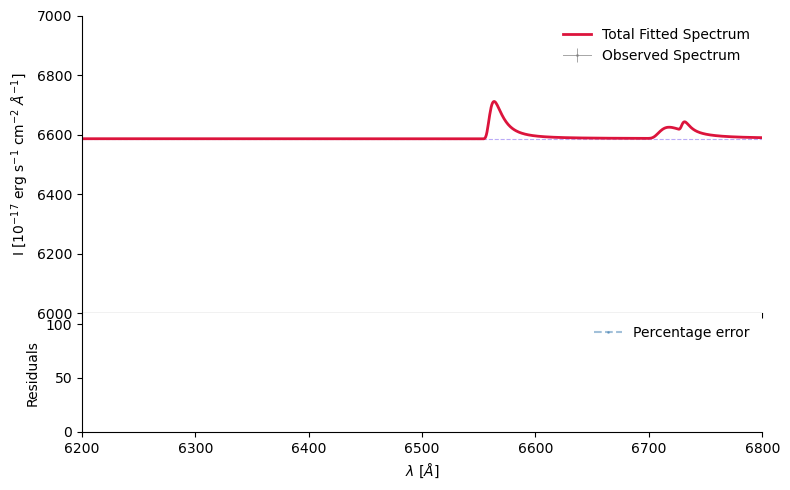

In [160]:
plotp0 = spsa.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], fitp0, x_zoom=(6200, 6800), y_zoom=(6000,7000)) #, x_zoom=(4800, 5050))

# plotp0 = spsa.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], fitp0, x_zoom=(6200, 6800))

In [127]:
plt.plot(spec0[:,0],spec0[:,1])
plt.xlim(6200,6800)
# plt.ylim(50,100)
# plt.ylim(-0.5e-17,40e-17)

(6200.0, 6800.0)

In [557]:
# '''
# Let's have a look at an individual fit of one of the emission lines, assuming it's Gaussian:
# Taking a Gaussian with the form  a * np.exp(-0.5*((x - b / c)**2))
# '''
# 
# # Define the emission line
# Emission_line = 'N-II,1'
# params = fit0[fit0['Line Name'] == Emission_line]
# 
# # Generate x-axis values
# x = spec0[:, 0]
# gauss_comp = []
# 
# for index, row in params.iterrows():
# 
#   # Define the Gaussian
#   b, a, c  = row["Parameters"] # Extract parameters from the row
#   # Calculate Gaussian & Append
#   gauss = a * np.exp(-(x-b)**2/(2*c**2))
#   gauss_comp.append(gauss)
# 
# gauss_total = np.sum(gauss_comp, axis=0)
# 
# # Normalise spectra (optional, depending on data)
# # spec0_norm = spec0[:, 1] / np.max(spec0[:, 1])
# 
# # Zoom into the plot
# lowerlim = b - 100
# upperlim = b + 100
# 
# # Plot the Gaussian distribution and normalised spectra
# plt.plot(x, spec0[:, 1], label='spectra')
# plt.plot(x, gauss_total, label=Emission_line + ' fit', ls='dashed')
# plt.xlim(lowerlim, upperlim)
# plt.xlabel('Wavelength')
# plt.ylabel('Flux')
# plt.legend()
# plt.show()

## Next step: elevating the number of components for a given list of lines.
This should be a good goal to hit for the next week. Let´s dive into it and discuss any progress on Friday. We have to:
* Create a function that takes as inputs:
 * A given dataframe with same structure as the input and output one from the run_mcmc_chains method.
 * A list of a subgroup of lines with components to ADD the current model (see cell below)
 * Based on that: take the parameters from the previous component(s) as guesses for the next ones, update correctly the dataframe, and run the run_mcmc_chains method again.



---

*Refinements*

 Add extra method that identifies when adding more components whether the centroid is blue or red shifted compared to the previous profile (calculate which side the mean residuals are shifted towards) and update further guesses

####A function to update components without recalculating minimum and maximum limits:



In [16]:
def update_components(dfparams, dfog, additional_components_dict, num):
    '''
    This function takes a dataframe of a given emission line spectral model and
    updates it with additional components, in consistency with the lines specified
    in the additional_components_dict.

    dfparams: output of earlier mcmc runs
    dfog: original dataframe of spectra
    additional_components_dict: a dictionary of the components to be added
    num: number of iterations to run the mcmc chains
    '''

    # Create a copy of the input dataframe to avoid modifying the original
    updated_df = dfparams.copy()
    df_zero = dfog.copy()

    # Sort by emission lines to add correct limits
    updated_df.sort_values(by=['Line Name']).reset_index(drop=True)
    df_zero.sort_values(by=['Line Name']).reset_index(drop=True)

    # Remove error column
    updated_df = updated_df.drop(['Parameter Errors'], axis=1)

    # Borrow Min and Max limits
    updated_df['Max Limits'] = df_zero['Max Limits']
    updated_df['Min Limits'] = df_zero['Min Limits']

    # Group the emission lines in the dataframe:
    # grouped = updated_df.groupby('Line Name')
    # updated_df = grouped.copy()
    # grouped

    # Iterate over the additional components dictionary

    for line, components in add_components_1.items():
      if (line in updated_df['Line Name'].values):
        print("Adding a {} component for {}".format(components[0], line))

        # Find the last instance of the element
        last_index = updated_df[updated_df['Line Name'] == line].index[-1]
        # Add a new component
        new_component_number = updated_df.loc[last_index, 'Component'] + 1

        # Copy the same parameters, updating the initial amplitude guess
        new_parameters = updated_df.loc[last_index, 'Parameters']
        new_parameters = [new_parameters[0], new_parameters[1]/2, new_parameters[2]]

        # Copy the limits from original dataframe
        new_parameter_max = updated_df.loc[last_index, 'Max Limits']
        new_parameter_max = [new_parameter_max[0], new_parameter_max[1]/2, new_parameter_max[2]]

        new_parameter_min = updated_df.loc[last_index, 'Min Limits']
        new_parameter_min = [new_parameter_min[0], new_parameter_min[1]/2, new_parameter_min[2]]

        new_row = {'Line Name': line, 'Component': new_component_number, 'Model': components[0], 'Parameters': new_parameters, 'Max Limits': new_parameter_max, 'Min Limits': new_parameter_min}
        updated_df = pd.concat([updated_df[:last_index + 1], pd.DataFrame([new_row]), updated_df[last_index + 1:]], ignore_index=True)

      else:
        print(f"{line} not found in the Spectrum.")

    # Run MCMC
    final_updated_df = spf.run_mcmc_chains(updated_df, spec0[:, 0], spec0[:, 1], spec0[:, 0], niter=num)


    # Return the updated dataframe
    return final_updated_df, updated_df


In [17]:
add_components_1 = {
	'O-III,1':  ['Gaussian'],
	'O-III,2':  ['Gaussian'],
	'H-β':      ['Gaussian'],
	'H-α':      ['Gaussian'],
	'S-II,1':   ['Gaussian'],
	'S-II,2':   ['Lorentzian']
	}

newdf, newdf0 = update_components(fit0, df0, add_components_1, num=5000)
display(newdf)

/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


O-III,1 not found in the Spectrum.
Adding a Gaussian component for O-III,2
Adding a Gaussian component for H-β
Adding a Gaussian component for H-α
Adding a Gaussian component for S-II,1
Adding a Lorentzian component for S-II,2
ndim inside sampler 54


100%|██████████| 5000/5000 [00:02<00:00, 2305.82it/s]


Successful! Convergence found.


Line Name       Model  Component  \
0         H-α    Gaussian          1   
1         H-α    Gaussian          2   
2         H-α    Gaussian          3   
3         H-β    Gaussian          1   
4         H-β    Gaussian          2   
5         H-β    Gaussian          3   
6      N-II,1    Gaussian          1   
7      N-II,2    Gaussian          1   
8     O-III,2    Gaussian          1   
9     O-III,2  Lorentzian          2   
10    O-III,2    Gaussian          3   
11     S-II,1    Gaussian          1   
12     S-II,1  Lorentzian          2   
13     S-II,1    Gaussian          3   
14     S-II,2    Gaussian          1   
15     S-II,2  Lorentzian          2   
16     S-II,2  Lorentzian          3   
17  Continuum   Continuum          0   

                                           Parameters  \
0   [5008.188652884457, 87.77369361386741, 1.53878...   
1   [5008.18955718415, 87.77365765922829, 1.706819...   
2   [5008.187800031258, 43.88557722000988, 1.70505...   
3   [4862.393943416211, 241.74391161118214, 1.1380...   
4   [4862.3915708786635, 241.74453646061932, 1.135...   
5   [4862.3953092926795, 120.87195431027727, 1.135...   
6   [6549.388762393669, 197.53613252539608, 1.5131...   
7   [6584.504659347165, 687.0344706337838, 1.38737...   
8   [6564.290176184276, 1032.5661341606292, 1.2914...   
9   [6564.289643345553, 1032.5666684231119, 1.2920...   
10  [6564.289762007974, 516.2838386476093, 1.29242...   
11  [6717.869776202705, 174.69573161212332, 1.3482...   
12  [6717.869945133163, 174.6950406295684, 1.49597...   
13  [6717.870850550717, 87.34914026073001, 1.49785...   
14  [6732.255531040571, 114.95971057419912, 1.3204...   
15  [6732.256966976296, 114.95773584877224, 1.4680...   
16  [6732.256620140581, 57.47833174367052, 1.46537...   
17  [-20.311842801910064, 6007.071941926818, 1.783...   

                                     Parameter Errors  
0   [0.0008713231539507041, 0.000964053361277357, ...  
1   [0.0010269330894217665, 0.0009494057559699003,...  
2   [0.00103347599002634, 0.0009582314858885837, 0...  
3   [0.0009534787568654136, 0.00108409040364954, 0...  
4   [0.0010501143465824303, 0.0009738053875286682,...  
5   [0.0009040931645601752, 0.0009334452666794643,...  
6   [0.0009182329283860645, 0.0009859460318942415,...  
7   [0.0008559336875739544, 0.0009256921427654842,...  
8   [0.0008960048877159755, 0.001099782269962282, ...  
9   [0.0009778917046298695, 0.0009988698735044596,...  
10  [0.0010048271815270827, 0.0009359498561152134,...  
11  [0.0010608406429301828, 0.0009314929263210288,...  
12  [0.000992919689745811, 0.0009121833075065181, ...  
13  [0.0009576766819862463, 0.001082826501395725, ...  
14  [0.0010825074872671174, 0.0010038517191297673,...  
15  [0.0010248667435632031, 0.0010014525706748753,...  
16  [0.0009094984614886783, 0.0009393092560246246,...  
17  [0.0009661189243279626, 0.0010331478936869188,...

In [18]:
add_components_1 = {
	'O-III,1':  ['Gaussian'],
	'O-III,2':  ['Gaussian'],
	'H-β':      ['Gaussian'],
	'H-α':      ['Gaussian'],
	'S-II,1':   ['Gaussian'],
	'S-II,2':   ['Lorentzian']
	}

secnewdf, secnewdf0 = update_components(newdf, newdf0, add_components_1, num=5000)
display(secnewdf)

O-III,1 not found in the Spectrum.
Adding a Gaussian component for O-III,2
Adding a Gaussian component for H-β
Adding a Gaussian component for H-α
Adding a Gaussian component for S-II,1
Adding a Lorentzian component for S-II,2
ndim inside sampler 69


/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:02<00:00, 1672.39it/s]


Successful! Convergence found.


Line Name       Model  Component  \
0         H-α    Gaussian          1   
1         H-α    Gaussian          2   
2         H-α    Gaussian          3   
3         H-α    Gaussian          4   
4         H-β    Gaussian          1   
5         H-β    Gaussian          2   
6         H-β    Gaussian          3   
7         H-β    Gaussian          4   
8      N-II,1    Gaussian          1   
9      N-II,2    Gaussian          1   
10    O-III,2    Gaussian          1   
11    O-III,2  Lorentzian          2   
12    O-III,2    Gaussian          3   
13    O-III,2    Gaussian          4   
14     S-II,1    Gaussian          1   
15     S-II,1  Lorentzian          2   
16     S-II,1    Gaussian          3   
17     S-II,1    Gaussian          4   
18     S-II,2    Gaussian          1   
19     S-II,2  Lorentzian          2   
20     S-II,2  Lorentzian          3   
21     S-II,2  Lorentzian          4   
22  Continuum   Continuum          0   

                                           Parameters  \
0   [5008.188887675732, 87.77598304066696, 1.53843...   
1   [5008.19025380881, 87.7727834345952, 1.7074666...   
2   [5008.188720177546, 43.88362020741652, 1.70645...   
3   [5008.187275511671, 21.942928821169073, 1.7022...   
4   [4862.393586798297, 241.74214787734985, 1.1383...   
5   [4862.390515381065, 241.74504414849648, 1.1355...   
6   [4862.394980932003, 120.87133398447634, 1.1357...   
7   [4862.394191073951, 60.4361190628239, 1.136203...   
8   [6549.3875859878635, 197.53774305851337, 1.513...   
9   [6584.506897791592, 687.0327862826546, 1.38756...   
10  [6564.291116795874, 1032.5669903212251, 1.2918...   
11  [6564.289380980169, 1032.5647554504867, 1.2922...   
12  [6564.29084486476, 516.2820546960314, 1.292574...   
13  [6564.2904546405725, 258.14138903740184, 1.292...   
14  [6717.871978590624, 174.69727945134838, 1.3472...   
15  [6717.870725350743, 174.69337307205973, 1.4956...   
16  [6717.871470288204, 87.34951965655702, 1.49795...   
17  [6717.870533142813, 43.674026578858765, 1.4976...   
18  [6732.255849397759, 114.95903700001797, 1.3197...   
19  [6732.2572410019675, 114.95787647249679, 1.467...   
20  [6732.25738998947, 57.477481243744776, 1.46480...   
21  [6732.257977640883, 28.738188034568296, 1.4666...   
22  [-20.311208523012397, 6007.0715298210325, 1.78...   

                                     Parameter Errors  
0   [0.0009996269657530177, 0.0010020743249313717,...  
1   [0.001018049119853424, 0.0009594394297463127, ...  
2   [0.0009970316225635504, 0.0010310457297899771,...  
3   [0.0010079856165717898, 0.001006890329134611, ...  
4   [0.001033087237571345, 0.0011112687337212174, ...  
5   [0.0009892971611595676, 0.0009271574142596697,...  
6   [0.0010001629028021648, 0.0009091619377342444,...  
7   [0.0009334576716513331, 0.0010950857953132373,...  
8   [0.0009828172525757216, 0.001076550573441516, ...  
9   [0.0009670678119150315, 0.0009482402809519314,...  
10  [0.0009533127904217628, 0.0009907719470826951,...  
11  [0.0009261311859935924, 0.0009353241369888319,...  
12  [0.0011061444411421047, 0.0008970729885604319,...  
13  [0.0009303425961075157, 0.0009832485162518544,...  
14  [0.0010136184177137175, 0.0009203280103493859,...  
15  [0.0010028405675123356, 0.0010215281795070542,...  
16  [0.0009674471813824491, 0.0008759521049381596,...  
17  [0.0010024767744739604, 0.0010063542657666818,...  
18  [0.0009328920666598011, 0.0011156232467225374,...  
19  [0.0009546639734877418, 0.0010493122247534315,...  
20  [0.0008964458657825468, 0.0009711062334378424,...  
21  [0.0009929741665956617, 0.0010280601043862194,...  
22  [0.0010186519244176529, 0.0010398902640870677,...

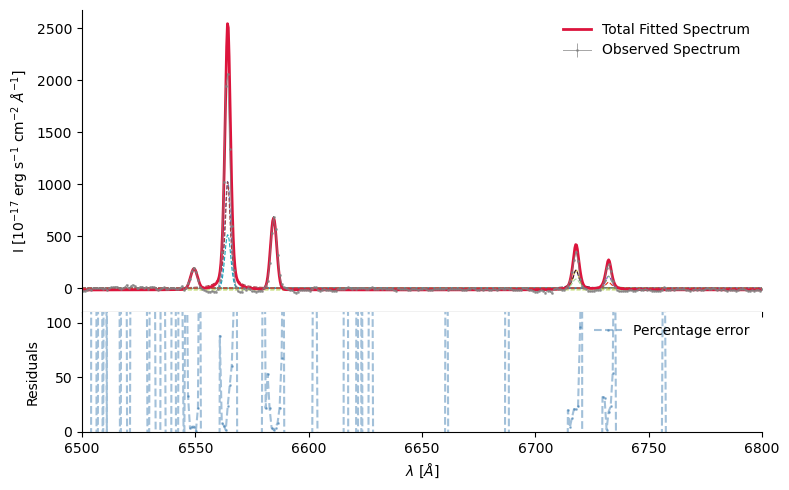

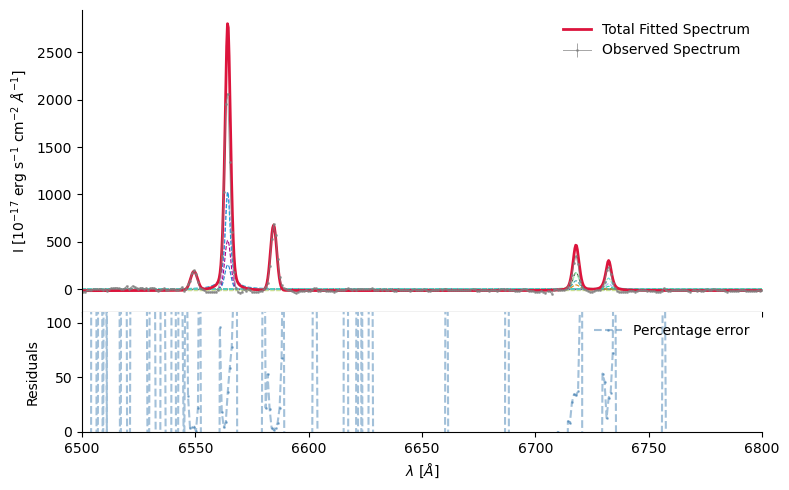

In [19]:
plot0 = sps.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], fit0, x_zoom=(6500, 6800)) #, x_zoom=(4800, 5050))
plot1 = sps.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], newdf, x_zoom=(6500, 6800)) #, x_zoom=(4800, 5050))
plot2 = sps.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], secnewdf, x_zoom=(6500, 6800)) #, x_zoom=(4800, 5050))

####A function to update components while recalculating minimum and maximum limits:


In [20]:
def minmaxlim(df):
  min_limits = []
  max_limits = []

  for index, row in df.iterrows():

      # Definitions
      # standard deviation
      sigma = row['Parameters'][2]
      minsig = 2.0
      maxsig = 1.5 * sigma
      # wavelength
      line_wavelength = row['Parameters'][0]
      min_line = line_wavelength - 2 * sigma
      max_line = line_wavelength + 2 * sigma
      # amplitude
      amplitude = row['Parameters'][1]
      # components
      ncomp = row['Component']

      # Adjust maximum amplitude based on component number
      # for the first component (which can have more than one or just one component afterwards)
      if ncomp == 1:
          # if there are multiple components for this line
          if df[df['Line Name'] == row['Line Name']].shape[0] > 1:
              amplitude_factor = 2
          else:
              amplitude_factor = 1
      # for the second component
      elif ncomp == 2:
          amplitude_factor = 2
      # for every other component
      else:
          amplitude_factor = 2**(ncomp-1)

      # Calculate Limits
      if row['Model'] == 'Gaussian':
          max_i = [max_line, amplitude * amplitude_factor, maxsig]
          min_i = [min_line, 0.                          , minsig]

      elif row['Model'] == 'Lorentzian':
          max_i = [max_line, amplitude * amplitude_factor, 1.11*maxsig]
          min_i = [min_line, 0.                          , 1.11*minsig]

      elif row['Model'] == 'Voigt':
          max_i = [max_line, amplitude * amplitude_factor, maxsig, 1.11*maxsig]
          min_i = [min_line, 0.                          , minsig, 1.11*minsig]

      elif row['Model'] == 'Continuum':
          max_i = [np.inf, np.inf, np.inf]
          min_i = [-np.inf, 0    , -np.inf]
      else:
          print("Model not defined.")

      min_limits.append(min_i)
      max_limits.append(max_i)

  return min_limits, max_limits

In [21]:
def update_components(dfparams, additional_components_dict, num):
    '''
    This function takes a dataframe of a given emission line spectral model and
    updates it with additional components, in consistency with the lines specified
    in the additional_components_dict.

    dfparams: output of earlier mcmc runs
    additional_components_dict: a dictionary of the components to be added
    num: number of iterations to run the mcmc chains
    '''

    # Create a copy of the input dataframe to avoid modifying the original
    updated_df = dfparams.copy()

    # Remove error column
    updated_df = updated_df.drop(['Parameter Errors'], axis=1)

    # Iterate over the additional components dictionary

    for line, components in add_components_1.items():
      if (line in updated_df['Line Name'].values):
        print("Adding a {} component for {}".format(components[0], line))

        # Find the last instance of the element
        last_index = updated_df[updated_df['Line Name'] == line].index[-1]
        # Add a new component
        new_component_number = updated_df.loc[last_index, 'Component'] + 1

        # Copy the same parameters, updating the initial amplitude guess
        new_parameters = updated_df.loc[last_index, 'Parameters']
        new_parameters = [new_parameters[0], new_parameters[1]/2, new_parameters[2]]

        new_row = {'Line Name': line, 'Component': new_component_number, 'Model': components[0], 'Parameters': new_parameters}
        updated_df = pd.concat([updated_df[:last_index + 1], pd.DataFrame([new_row]), updated_df[last_index + 1:]], ignore_index=True)

      else:
        print(f"{line} not found in the Spectrum.")

    # Calculate limits

    min_limits, max_limits = minmaxlim(updated_df)

    updated_df['Max Limits'] = pd.Series(max_limits)
    updated_df['Min Limits'] = pd.Series(min_limits)

    # Run MCMC
    final_updated_df = spf.run_mcmc_chains(updated_df, spec0[:, 0], spec0[:, 1], spec0[:, 0], niter=num)

    # Return the updated dataframe
    return final_updated_df


In [22]:
add_components_1 = {
	'O-III,1':  ['Gaussian'],
	'O-III,2':  ['Gaussian'],
	'H-β':      ['Gaussian'],
	'H-α':      ['Gaussian'],
	'S-II,1':   ['Gaussian'],
	'S-II,2':   ['Lorentzian']
	}

newdf = update_components(fit0, add_components_1, num=100)
display(newdf)

/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


O-III,1 not found in the Spectrum.
Adding a Gaussian component for O-III,2
Adding a Gaussian component for H-β
Adding a Gaussian component for H-α
Adding a Gaussian component for S-II,1
Adding a Lorentzian component for S-II,2
ndim inside sampler 54


100%|██████████| 100/100 [00:00<00:00, 2044.07it/s]

Successful! Convergence found.


Line Name       Model  Component  \
0         H-α    Gaussian          1   
1         H-α    Gaussian          2   
2         H-α    Gaussian          3   
3         H-β    Gaussian          1   
4         H-β    Gaussian          2   
5         H-β    Gaussian          3   
6      N-II,1    Gaussian          1   
7      N-II,2    Gaussian          1   
8     O-III,2    Gaussian          1   
9     O-III,2  Lorentzian          2   
10    O-III,2    Gaussian          3   
11     S-II,1    Gaussian          1   
12     S-II,1  Lorentzian          2   
13     S-II,1    Gaussian          3   
14     S-II,2    Gaussian          1   
15     S-II,2  Lorentzian          2   
16     S-II,2  Lorentzian          3   
17  Continuum   Continuum          0   

                                           Parameters  \
0   [5008.187468212249, 87.77498834775398, 1.53768...   
1   [5008.188352697405, 87.77346227483272, 1.70567...   
2   [5008.1869704676055, 43.8867498832218, 1.70574...   
3   [4862.395438406361, 241.7427852467462, 1.13567...   
4   [4862.393813744253, 241.7421235669694, 1.13463...   
5   [4862.393453534628, 120.86896798940612, 1.1336...   
6   [6549.389501436428, 197.53633125969554, 1.5113...   
7   [6584.504162312949, 687.0337848317647, 1.38739...   
8   [6564.290911683636, 1032.5642085930322, 1.2916...   
9   [6564.2919424498405, 1032.564356138282, 1.2913...   
10  [6564.290682784482, 516.2820715558869, 1.29256...   
11  [6717.870340332998, 174.69549643890227, 1.3479...   
12  [6717.86828124998, 174.69449649995275, 1.49699...   
13  [6717.869952818516, 87.3479088846159, 1.497238...   
14  [6732.252338697321, 114.95924527325646, 1.3213...   
15  [6732.256568897251, 114.95798217792614, 1.4681...   
16  [6732.256495675362, 57.47818551005172, 1.46664...   
17  [-20.310722994465607, 6007.071335515239, 1.782...   

                                     Parameter Errors  
0   [0.0010435763387365844, 0.000978256665585592, ...  
1   [0.000952166704944943, 0.0010559284924007437, ...  
2   [0.0009642516234764377, 0.0009790995081488106,...  
3   [0.0009396388892643289, 0.0010291250286973501,...  
4   [0.0010005312327228412, 0.0010524979743108543,...  
5   [0.0009859434154778726, 0.001014819499833661, ...  
6   [0.0009790292245269985, 0.0010616380941134206,...  
7   [0.0009586073176838193, 0.0011155514364681496,...  
8   [0.0009293197850489673, 0.0008973021616760634,...  
9   [0.0009743797510564812, 0.0010294326766550042,...  
10  [0.0009900161620565238, 0.0010802558775396863,...  
11  [0.0009880856798400461, 0.0010354369497903805,...  
12  [0.0011307156737705474, 0.0009441573029261691,...  
13  [0.0010953397078709915, 0.0010092616498647185,...  
14  [0.000964223567616763, 0.0010675410859275541, ...  
15  [0.0010293924501247793, 0.0010574543843618726,...  
16  [0.0010981457550267978, 0.000935990121084108, ...  
17  [0.0010333663944350616, 0.0010176205399195374,...

In [23]:
newdf2 = update_components(newdf, add_components_1, num=100)
display(newdf2)

/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


O-III,1 not found in the Spectrum.
Adding a Gaussian component for O-III,2
Adding a Gaussian component for H-β
Adding a Gaussian component for H-α
Adding a Gaussian component for S-II,1
Adding a Lorentzian component for S-II,2
ndim inside sampler 69


100%|██████████| 100/100 [00:00<00:00, 582.83it/s]

Successful! Convergence found.


Line Name       Model  Component  \
0         H-α    Gaussian          1   
1         H-α    Gaussian          2   
2         H-α    Gaussian          3   
3         H-α    Gaussian          4   
4         H-β    Gaussian          1   
5         H-β    Gaussian          2   
6         H-β    Gaussian          3   
7         H-β    Gaussian          4   
8      N-II,1    Gaussian          1   
9      N-II,2    Gaussian          1   
10    O-III,2    Gaussian          1   
11    O-III,2  Lorentzian          2   
12    O-III,2    Gaussian          3   
13    O-III,2    Gaussian          4   
14     S-II,1    Gaussian          1   
15     S-II,1  Lorentzian          2   
16     S-II,1    Gaussian          3   
17     S-II,1    Gaussian          4   
18     S-II,2    Gaussian          1   
19     S-II,2  Lorentzian          2   
20     S-II,2  Lorentzian          3   
21     S-II,2  Lorentzian          4   
22  Continuum   Continuum          0   

                                           Parameters  \
0   [5008.188895874983, 87.77593944525384, 1.53798...   
1   [5008.188211160829, 87.77252025564115, 1.70655...   
2   [5008.187285362319, 43.885914398493306, 1.7064...   
3   [5008.188096074622, 21.944369214935055, 1.7050...   
4   [4862.396061591276, 241.74378133896258, 1.1375...   
5   [4862.39254637353, 241.74112132886646, 1.13428...   
6   [4862.394383997218, 120.86784029441782, 1.1336...   
7   [4862.394338540308, 60.43522671438443, 1.13218...   
8   [6549.388524069734, 197.53682591116205, 1.5136...   
9   [6584.504427301554, 687.0340281872532, 1.38510...   
10  [6564.290941635768, 1032.563695560495, 1.29186...   
11  [6564.290619644236, 1032.5641074780062, 1.2913...   
12  [6564.290908999374, 516.2829369694808, 1.29401...   
13  [6564.289078307627, 258.1398849824265, 1.29141...   
14  [6717.870170582536, 174.69502856682485, 1.3479...   
15  [6717.8683506569605, 174.69667101587396, 1.498...   
16  [6717.869593835305, 87.35005583332857, 1.49607...   
17  [6717.869663004676, 43.67223552967827, 1.49671...   
18  [6732.253916549077, 114.95953975385363, 1.3217...   
19  [6732.2561756587465, 114.95763149926049, 1.466...   
20  [6732.25641308435, 57.478711162417895, 1.46657...   
21  [6732.255136217696, 28.738279637948988, 1.4674...   
22  [-20.310765979271416, 6007.072649338812, 1.782...   

                                     Parameter Errors  
0   [0.000906803983018656, 0.00099116169229017, 0....  
1   [0.0008801209918514096, 0.0008939905146466765,...  
2   [0.0009231079671052534, 0.0009305428342391462,...  
3   [0.0009264106693898578, 0.0010731253199081068,...  
4   [0.0008802085698019892, 0.001080402583481177, ...  
5   [0.0010830801792980909, 0.0009222703283413225,...  
6   [0.0010230866900507929, 0.0010547464931523994,...  
7   [0.0009289093477438354, 0.0009761777274514761,...  
8   [0.0010722843052874457, 0.000952526901523616, ...  
9   [0.0010415568052177613, 0.0011360984016565952,...  
10  [0.0010530350713004865, 0.0009063605559624562,...  
11  [0.0010006962327828695, 0.0009712171811574238,...  
12  [0.0009266401611277929, 0.0009667446068080205,...  
13  [0.0010079679306808744, 0.0009886745016946372,...  
14  [0.001036431293710846, 0.0009615385762720195, ...  
15  [0.0009764271128231938, 0.0010642459667236717,...  
16  [0.0008587565424898397, 0.0009870486087675862,...  
17  [0.0010461214007063807, 0.0010909610106630931,...  
18  [0.0010209189579604644, 0.0009664476758354319,...  
19  [0.0010336304606872193, 0.0008888291594315444,...  
20  [0.0008979024375733246, 0.0010077697226312638,...  
21  [0.0009881067205858793, 0.0010753495881912637,...  
22  [0.0009198736336289441, 0.0009450527189924735,...

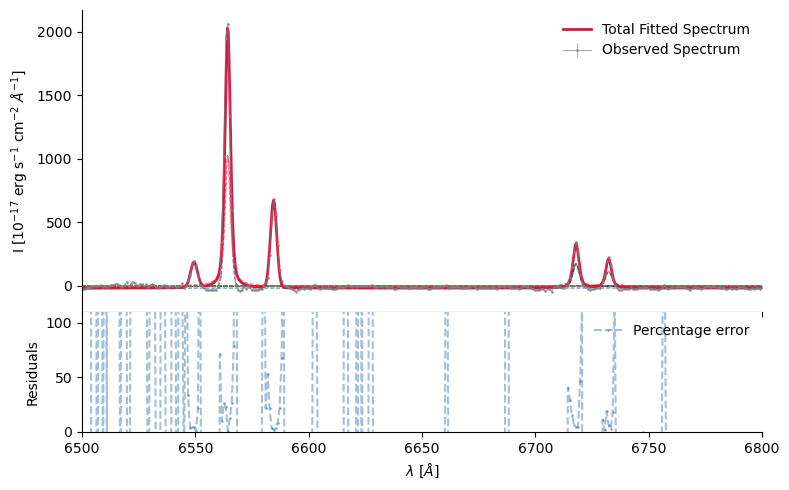

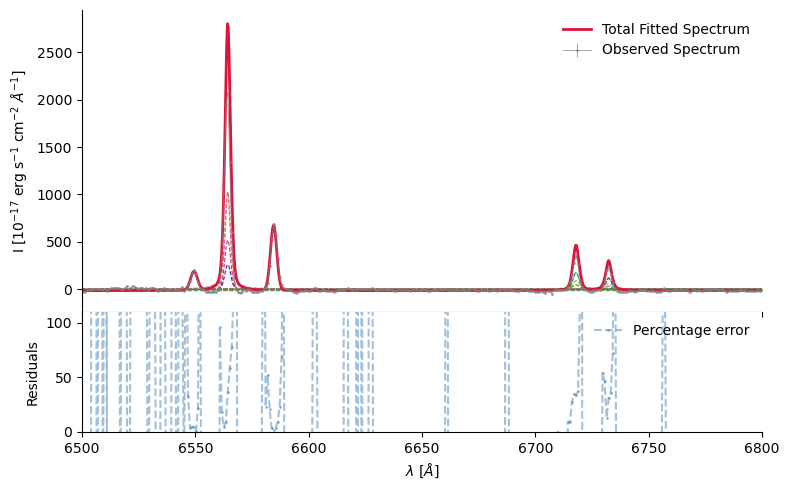

In [24]:
plot0 = sps.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], fit0, x_zoom=(6500, 6800)) #, x_zoom=(4800, 5050))
plot1 = sps.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], newdf, x_zoom=(6500, 6800))
plot2 = sps.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], newdf2, x_zoom=(6500, 6800))

### Remarks for this week for 19 - 23 August

Hi Aksita,
I've already uploaded a set of many AGN spectra, in the route inside the new_spl folder:

new_spl/input_data

please consider from now the paths accordingly. This folder contain:
* MaNGA integrated (single) spectra; the nomenclature for this files is:
_manga-plate-ifu-*Reff*.fits_. These are integrating at different apertures, that is OK, we are seeking to adapt the code to properly work on an heterogeneous sample of spectra.
* PAQS simulated spectra. These are simulated quasar spectra produced to calibrate the 4MOST (a survey still to be launched) reduction pipeline. The nomenclature of these files is: _PAQS_OBJECTID_LJ1.fits_
* There is one complete manga cube: _manga-11831-12702-LOGCUBE-SPX-MILESHC-MASTARSSP.fits_
you can explore this fits cube either with a tool like qfitsview or directly with python, with the astropy.io.fits package (which I recommend)

By now, I would ask you to:

* Explore (that is; open, extract, and plot) these spectra.
* Work on a function to iterate over a list of files, open the spectra, and store them in a common object with identifiers (maybe a dictionary containing SNR, spectra, redshift) to afterwards apply the process we have worked on. This execution might be useful at once because that might be the most efficient way to proceed for complete datacubes.
* Calculate redshift using [OIII] or determine systemic redshift with other elements, and SNR

Start diving into this for this week, meanwhile I review and translate into a script what we have done until now.

Cheers, and see you on Wednesday!



### One MANGA Cube

In [25]:
import ipywidgets as widgets
from IPython.display import display

In [26]:
fitsfile = ('/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-11831-12702-LOGCUBE-SPX-MILESHC-MASTARSSP.fits.gz')
hdu_file = fits.open(fitsfile)
hdu_file.info()

Filename: /Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-11831-12702-LOGCUBE-SPX-MILESHC-MASTARSSP.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     126   ()      
  1  FLUX          1 ImageHDU        45   (74, 74, 4563)   float32   
  2  IVAR          1 ImageHDU        46   (74, 74, 4563)   float32   
  3  MASK          1 ImageHDU        45   (74, 74, 4563)   int16   
  4  LSF           1 ImageHDU        44   (74, 74, 4563)   float32   
  5  WAVE          1 ImageHDU         9   (4563,)   float32   
  6  REDCORR       1 ImageHDU         9   (4563,)   float32   
  7  MODEL         1 ImageHDU        44   (74, 74, 4563)   float32   
  8  MODEL_MASK    1 ImageHDU        44   (74, 74, 4563)   int16   
  9  EMLINE        1 ImageHDU        43   (74, 74, 4563)   float32   
 10  STELLAR       1 ImageHDU        44   (74, 74, 4563)   float32   
 11  STELLAR_MASK    1 ImageHDU        44   (74, 74, 4563)   int16   
 12  BINID     

In [27]:
mangaflux = hdu_file['FLUX'].data
mangawave = hdu_file['WAVE'].data
mangaerr = hdu_file['IVAR'].data

In [28]:
def visualise_cube_slice(wavelength_index):
    image_slice = mangaflux[wavelength_index, :, :]
    plt.imshow(image_slice, cmap='viridis')
    plt.title(f"Heatmap for Wavelength Index {wavelength_index}")
    plt.xlabel("x pix")
    plt.ylabel("y pix")
    plt.colorbar()
    plt.show()

# slider widget to select the wavelength index
wavelength_slider = widgets.IntSlider(min=0, max=mangaflux.shape[0]-1, value=0, description='WV')

# connect the slider to the cube visualiser function
widgets.interact(visualise_cube_slice, wavelength_index=wavelength_slider);

interactive(children=(IntSlider(value=0, description='WV', max=4562), Output()), _dom_classes=('widget-interac…

In [29]:
def visualise_data_slice(xpix,ypix):
    data_slice = mangaflux[:, ypix, xpix]
    plt.plot(data_slice)
    plt.title("Spectrum for Pixel [{}, {}]".format(xpix,ypix))
    plt.xlabel("X pixel")
    plt.ylabel("Y pixel")
    plt.show()

# slider widget to select the x and y pixel index
ex = widgets.IntSlider(min=0, max=mangaflux.shape[1]-1, value=0, description='X')
why = widgets.IntSlider(min=0, max=mangaflux.shape[2]-1, value=0, description='Y')

# connect the slider to the flux spectra function
widgets.interact(visualise_data_slice, xpix=ex,ypix=why);

interactive(children=(IntSlider(value=0, description='X', max=73), IntSlider(value=0, description='Y', max=73)…

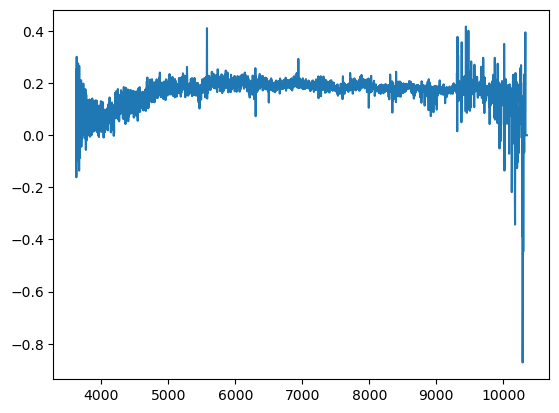

In [30]:
# for further investigation
xpix = 30
ypix = 40

plt.plot(mangawave, mangaflux[:,xpix,ypix])
plt.show()

### One MANGA file

In [31]:
fitsfile = ('/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-7815-6104_Reff_spec.fits')
hdu_file = fits.open(fitsfile)
hdu_file.info()

Filename: /Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-7815-6104_Reff_spec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     28   4563R x 4C   [D, D, D, D]   


In [32]:
data = hdu_file[1].data

In [33]:
manga_wave = data['wavelength']
manga_flux = data['flux']
manga_error = data['flux_error']

print("Wavelength has shape ", len(manga_wave))
print("Flux has shape ", len(manga_flux))
print("Error has shape ", len(manga_error))

Wavelength has shape  4563
Flux has shape  4563
Error has shape  4563


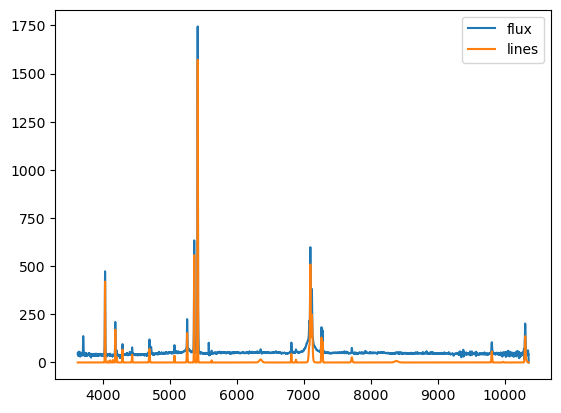

In [34]:
plt.plot(manga_wave, manga_flux, label ='flux')
plt.plot(manga_wave,hdu_file[1].data['emlines'],label ='lines')

plt.legend()
plt.show()

In [35]:
fitsfile = ('/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-9000-1901-0.5Reff.fits')
hdu_file = fits.open(fitsfile)
hdu_file.info()

Filename: /Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-9000-1901-0.5Reff.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     25   4487R x 3C   [D, D, D]   


In [36]:
data = hdu_file[1].data

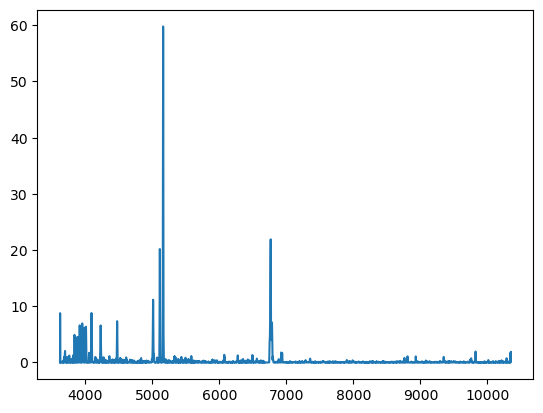

In [37]:
plt.plot(hdu_file[1].data['wavelength'], hdu_file[1].data['flux_lines'])
plt.show()

### PAQS

In [38]:
fitsfile = ('/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_000439.86-271539.36_LJ1.fits')
hdu_file = fits.open(fitsfile)
hdu_file.info()

Filename: /Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_000439.86-271539.36_LJ1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   ()      
  1  PHASE3SPECTRUM    1 BinTableHDU     88   1R x 6C   [23198E, 23198E, 23198E, 23198J, 23198E, 23198E]   


In [39]:
data = hdu_file[1].data

In [40]:
paqs_wave = data['WAVE']
paqs_flux = data['FLUX']
paqs_error = data['ERR_FLUX']

print("Wavelength has shape ", len(paqs_wave))
print("Flux has shape ", len(paqs_flux))
print("Error has shape ", len(paqs_error))

Wavelength has shape  1
Flux has shape  1
Error has shape  1


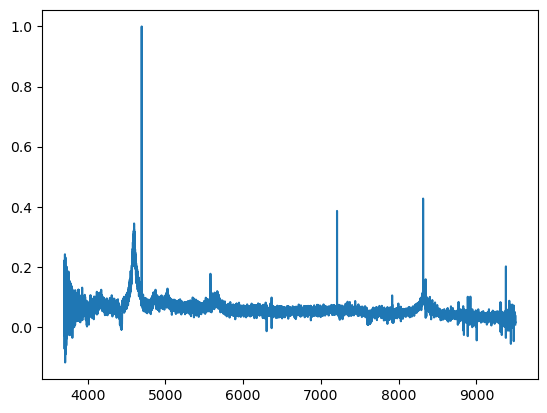

In [41]:
plt.plot(paqs_wave[0], paqs_flux[0]/max(paqs_flux[0]), label ='flux')
plt.show()

### Multiple files

In [45]:
def extract_data(array):
    """
    Extracts data from multidimensional arrays
    """

    if array.ndim == 1:
        return array
    elif array.ndim == 2:
        return array.flatten()
    else:
        raise ValueError("Unsupported array dimension: {}".format(array.ndim))

In [46]:
def extract_astronomical_data(filename, verbose=True, wavelength_name=None, flux_name=None, error_name=None):
    """
    Extracts wavelength, flux, and error (when applicable) from a FITS file,
    handling variations in keyword syntax and layout across surveys.

    Params:


    Future edits: Add dictionary of keywords from public data surveys? Or maybe a dictionary where user
    just has to define what survey it's from? If keyword not found and user knows keyword, maybe change
    function to have the option to add keyword? Possibly add 3D - 1D data analysis
    """

    try:
        with fits.open(filename) as hdul:

            # Search for keywords
            potential_keywords = ['wavelength', 'WAVE', 'lambda']
            for keyword in potential_keywords:
                if keyword in hdul[1].columns.names:
                    wavelength_name = keyword
                    break

            potential_keywords = ['flux', 'FLUX', 'f_lambda', 'flux_lines','total flux']
            for keyword in potential_keywords:
                if keyword in hdul[1].columns.names:
                    flux_name = keyword
                    break

            potential_keywords = ['error', 'ERR', 'flux_error', 'ERR_FLUX','flux error']
            for keyword in potential_keywords:
                if keyword in hdul[1].columns.names:
                    error_name = keyword
                    break

            # Define arrays
            if wavelength_name:
                wave = hdul[1].data[wavelength_name]
            else:
                if verbose:
                    print("Warning: Keyword for wavelength not found.")
                pass

            if flux_name:
                flux = hdul[1].data[flux_name]
            else:
                if verbose:
                    print("Warning: Keyword for flux not found.")
                pass

            if error_name:
                err = hdul[1].data[error_name]
            else:
                if verbose:
                    print("Warning: Keyword for error not found.")
                pass

            # Create spectra with same form as Jose Luis

            wave = extract_data(wave)
            flux = extract_data(flux)
            err = extract_data(err)

            spec = np.array([wave, flux, err]).T

            return spec

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None

#### Extract Redshift

In [47]:
SNR_emission_lines = {
	'He-II,1': {'wavelength':[3202.15]},
	'He-II,2': {'wavelength':[4685.74]},
	'Ne-V,1':  {'wavelength':[3345.81]},
	'Ne-V,2':  {'wavelength':[3425.81]},
	'O-II,1':  {'wavelength':[3726.03]},
	'O-II,2':  {'wavelength':[3728.73]},
	'Ne-III,1': {'wavelength':[3868.69]},
	'Ne-III,2': {'wavelength':[3967.40]},
	'H-ζ':    {'wavelength':[3889.05]},
	'H-ε':    {'wavelength':[3970.07]},
	'H-δ':    {'wavelength':[4101.73]},
	'H-γ':    {'wavelength':[4340.46]},
	'O-III,0':  {'wavelength':[4363.15]},
	'O-III,1':  {'wavelength':[4958.83]},
	'O-III,2':  {'wavelength':[5006.77]},
	'Ar-IV,1':  {'wavelength':[4711.30]},
	'Ar-IV,2':  {'wavelength':[4740.10]},
	'H-β':     {'wavelength':[4861.32]},
	'N-I,1':    {'wavelength':[5197.90]},
	'N-I,2':    {'wavelength':[5200.39]},
	'He-I':   {'wavelength':[5875.60]},
	'O-I,1':   {'wavelength':[6300.20]},
	'O-I,2':   {'wavelength':[6363.67]},
	'N-II,1':   {'wavelength':[6547.96]},
	'N-II,2':   {'wavelength':[6583.34]},
	'H-α':     {'wavelength':[6562.80]},
	'S-II,1':  {'wavelength': [6716.31]},
	'S-II,2':   {'wavelength':[6730.68]},
	'Ar-III': {'wavelength':[7135.67]},
	}

In [48]:
from scipy.signal import find_peaks

In [49]:
# UNCOMMENT AFTER TESTING

def calculate_redshift(wavelength, flux, emission_lines):

    # Find emission line peaks
    peaks, _ = find_peaks(flux/max(flux), height=0.4)                                      # ADJUST
    wavepeaks = np.array(wavelength[peaks])

    # Generate a grid of redshifts
    redshifts = np.arange(0, 3.5, 0.01)

    # Calculate chi-squared values for each redshift
    chi_squared_values = []

    for redshift in redshifts:

        # Deredshift the spectrum
        deredshifted_wavelengths = wavepeaks / (1 + redshift)

        # Calculate chi-squared for each emission line
        chi_squared_line = []

        for line in emission_lines:
            # Define emission line
            rest_wavelength = emission_lines[line]['wavelength'][0]

            # Find the index of the closest value in the array
            closest_index = np.argmin(np.abs(deredshifted_wavelengths - rest_wavelength))

            # Get the closest value and the difference
            closest_value = deredshifted_wavelengths[closest_index]
            difference = np.abs(closest_value - rest_wavelength)

            chi_squared_line.append(difference)

        # Calculate total chi-squared for the redshift
        chi_squared_total = np.sum(chi_squared_line)
        chi_squared_values.append(chi_squared_total)


    # Find the redshift with the minimum chi-squared value
    best_redshift_index = np.argmin(chi_squared_values)
    best_redshift = redshifts[best_redshift_index]
    best_chi_squared = chi_squared_values[best_redshift_index]

    deredshifted_wavelengths1 = wavelength / (1 + best_redshift)

    return best_redshift, best_chi_squared

In [50]:
redshift,_ = calculate_redshift(paqs_wave[0], paqs_flux[0], SNR_emission_lines)
if redshift is not None:
    print(f"Calculated redshift: {redshift}")
else:
    print("No redshift could be calculated.")

Calculated redshift: 0.23


In [ ]:
plt.plot(paqs_wave[0], paqs_flux[0], label ='original',color = 'red',alpha= 0.5)
plt.plot(paqs_wave[0]/(1+redshift), paqs_flux[0], label ='de-red',color='blue', alpha = 1)

# Plot vertical lines for emission lines
for line_name, line_data in SNR_emission_lines.items():
    for rest_wavelength in line_data['wavelength']:
        plt.vlines(rest_wavelength,ymin=min(paqs_flux[0]),ymax=max(paqs_flux[0]), color='black', linestyle='-.',alpha = 0.8)
        # plt.axvline(rest_wavelength, color='black', linestyle='--',alpha = 0.2)

plt.xlabel('Wavelength')
plt.ylabel('Flux')

plt.legend()
plt.show()

In [52]:
redshift,_ = calculate_redshift(manga_wave, manga_flux, SNR_emission_lines)
if redshift is not None:
    print(f"Calculated redshift: {redshift}")
else:
    print("No redshift could be calculated.")

Calculated redshift: 0.14


In [ ]:
plt.plot(manga_wave, manga_flux, label ='observed',color = 'red',alpha= 0.5)
plt.plot(manga_wave/(1+redshift), manga_flux, label ='rest',color='blue', alpha = 1)

# Plot vertical lines for emission lines
for line_name, line_data in SNR_emission_lines.items():
    for rest_wavelength in line_data['wavelength']:
        plt.vlines(rest_wavelength,ymin=min(manga_flux),ymax=max(manga_flux), color='black', linestyle='-.',alpha = 0.8)
        # plt.axvline(rest_wavelength, color='black', linestyle='--',alpha = 0.2)

plt.xlabel('Wavelength')
plt.ylabel('Flux')

plt.legend()
plt.show()

In [54]:
SNR_emission_lines = {
	'He-II,1': {'wavelength':[3202.15]},
	'He-II,2': {'wavelength':[4685.74]},
	'Ne-V,1':  {'wavelength':[3345.81]},
	'Ne-V,2':  {'wavelength':[3425.81]},
	'O-II,1':  {'wavelength':[3726.03]},
	'O-II,2':  {'wavelength':[3728.73]},
	'Ne-III,1': {'wavelength':[3868.69]},
	'Ne-III,2': {'wavelength':[3967.40]},
	'H-ζ':    {'wavelength':[3889.05]},
	'H-ε':    {'wavelength':[3970.07]},
	'H-δ':    {'wavelength':[4101.73]},
	'H-γ':    {'wavelength':[4340.46]},
	'O-III,0':  {'wavelength':[4363.15]},
	'O-III,1':  {'wavelength':[4958.83]},
	'O-III,2':  {'wavelength':[5006.77]},
	'Ar-IV,1':  {'wavelength':[4711.30]},
	'Ar-IV,2':  {'wavelength':[4740.10]},
	'H-β':     {'wavelength':[4861.32]},
	'N-I,1':    {'wavelength':[5197.90]},
	'N-I,2':    {'wavelength':[5200.39]},
	'He-I':   {'wavelength':[5875.60]},
	'O-I,1':   {'wavelength':[6300.20]},
	'O-I,2':   {'wavelength':[6363.67]},
	'N-II,1':   {'wavelength':[6547.96]},
	'N-II,2':   {'wavelength':[6583.34]},
	'H-α':     {'wavelength':[6562.80]},
	'S-II,1':  {'wavelength': [6716.31]},
	'S-II,2':   {'wavelength':[6730.68]},
	'Ar-III': {'wavelength':[7135.67]},
	'O VI': {'wavelength': [1033.82]},
	'Ly-alpha': {'wavelength': [1215.24]},
	'N V': {'wavelength': [1305.53]},
	'Si IV + O IV': {'wavelength': [1549.48]},
	'C IV': {'wavelength': [1640.40]},
	'C III': {'wavelength': [2326.00]},
	'Mg II': {'wavelength': [3346.79]},
	}

In [55]:
# UNCOMMENT AFTER TESTING

def calculate_redshift(spectrum, emission_lines):

    wavelength = spectrum[:, 0]
    flux = spectrum[:, 1]
    errors = spectrum[:, 2]

    # Find emission line peaks
    peaks, _ = find_peaks(flux/max(flux), height=0.4)                                      # ADJUST
    wavepeaks = np.array(wavelength[peaks])

    # Generate a grid of redshifts
    redshifts = np.arange(0, 3.5, 0.01)

    # Calculate chi-squared values for each redshift
    chi_squared_values = []

    for redshift in redshifts:

        # Deredshift the spectrum
        deredshifted_wavelengths = wavepeaks / (1 + redshift)

        # Calculate chi-squared for each emission line
        chi_squared_line = []

        for line in emission_lines:
            # Define emission line
            rest_wavelength = emission_lines[line]['wavelength'][0]

            # Find the index of the closest value in the array
            closest_index = np.argmin(np.abs(deredshifted_wavelengths - rest_wavelength))

            # Get the closest value and the difference
            closest_value = deredshifted_wavelengths[closest_index]
            difference = np.abs(closest_value - rest_wavelength)

            chi_squared_line.append(difference)

        # Calculate total chi-squared for the redshift
        chi_squared_total = np.sum(chi_squared_line)
        chi_squared_values.append(chi_squared_total)


    # Find the redshift with the minimum chi-squared value
    best_redshift_index = np.argmin(chi_squared_values)
    best_redshift = redshifts[best_redshift_index]
    best_chi_squared = chi_squared_values[best_redshift_index]

    deredshifted_wavelengths1 = wavelength / (1 + best_redshift)

    return best_redshift, best_chi_squared

#### Extract Redshift P.2

In [76]:
SNR_emission_lines = {
  'He-II,1': {'wavelength': [3202.15]},
  'He-II,2': {'wavelength': [4685.74]},
  'Ne-V,1':  {'wavelength': [3345.81]},
  'Ne-V,2':  {'wavelength': [3425.81]},
  'O-II,1':  {'wavelength': [3726.03]},
  'O-II,2':  {'wavelength': [3728.73]},
  'Ne-III,1': {'wavelength': [3868.69]},
  'Ne-III,2': {'wavelength': [3967.40]},
  'H-ζ':    {'wavelength': [3889.05]},
  'H-ε':    {'wavelength': [3970.07]},
  'H-δ':    {'wavelength': [4101.73]},
  'H-γ':    {'wavelength': [4340.46]},
  'O-III,0':  {'wavelength': [4363.15]},
  'O-III,1':  {'wavelength': [4958.83]},
  'O-III,2':  {'wavelength': [5006.77]},
  'Ar-IV,1':  {'wavelength': [4711.30]},
  'Ar-IV,2':  {'wavelength': [4740.10]},
  'H-β':     {'wavelength': [4861.32]},
  'N-I,1':    {'wavelength': [5197.90]},
  'N-I,2':    {'wavelength': [5200.39]},
  'He-I':   {'wavelength': [5875.60]},
  'O-I,1':   {'wavelength': [6300.20]},
  'O-I,2':   {'wavelength': [6363.67]},
  'N-II,1':   {'wavelength': [6547.96]},
  'N-II,2':   {'wavelength': [6583.34]},
  'H-α':     {'wavelength': [6562.80]},
  'S-II,1':  {'wavelength': [6716.31]},
  'S-II,2':   {'wavelength': [6730.68]},
  'Ar-III': {'wavelength': [7135.67]},
  'O VI': {'wavelength': [1033.82]},
  'Ly-alpha': {'wavelength': [1215.24]},
  'N V': {'wavelength': [1305.53]},
  'C II': {'wavelength': [1397.61]},
  'Si IV': {'wavelength': [1399.80]},
  'C IV': {'wavelength': [1640.40]},
  'He II': {'wavelength': [1665.85]},
  'Al III': {'wavelength': [1908.73]},
  'Mg II': {'wavelength': [3346.79]},
  'Ne VI': {'wavelength': [3727.09]}
}

In [ ]:
# !pip install specutils

In [60]:
from specutils.analysis import template_match
from specutils import Spectrum1D
from astropy.nddata import StdDevUncertainty

In [61]:
tempfile = ('/Users/aksitadeo/PycharmProjects/spelfig_aksita/template/liner_template.fits')
temp_file = fits.open(tempfile)
temp_file.info()

Filename: /Users/aksitadeo/PycharmProjects/spelfig_aksita/template/liner_template.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   ()      
  1                1 BinTableHDU     16   1264R x 2C   [1E, 1E]   


In [63]:
template_spectra = []

dir = '/Users/aksitadeo/PycharmProjects/spelfig_aksita/template/'
template_filenames = [f for f in os.listdir(dir) if f.endswith('.fits')]

for filename in template_filenames:
    full_dir = os.path.join(dir, filename)
    template_data = fits.open(full_dir)

    wavelength = template_data[1].data['WAVELENGTH'] * u.Angstrom
    flux = template_data[1].data['FLUX'] * u.Jy

    spect0 = Spectrum1D(flux=flux, spectral_axis=wavelength)
    template_spectra.append(spect0)

In [64]:
testerdata = Spectrum1D(flux=manga_flux * u.Jy, spectral_axis=manga_wave * u.Angstrom, uncertainty = StdDevUncertainty(manga_error), unit='Jy')

testerred = np.arange(0.05, 2.4, 0.01)

In [65]:
normspec, redshiftspec, chiindexspec, chiminspec, chilist = template_match(testerdata, template_spectra, redshift=testerred)

In [66]:
redshiftspec

0.08000000000000002

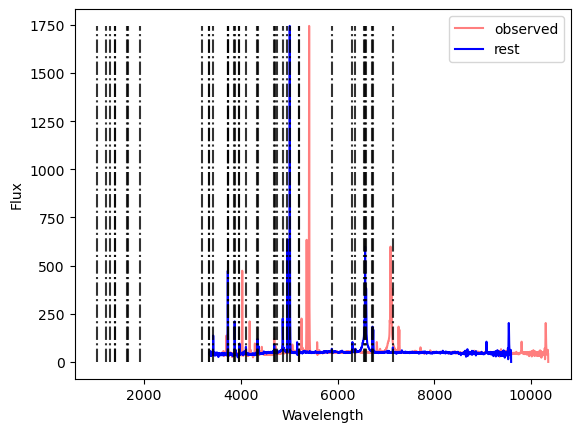

In [68]:
plt.plot(manga_wave, manga_flux, label ='observed',color = 'red',alpha= 0.5)
plt.plot(manga_wave/(1+redshiftspec), manga_flux, label ='rest',color='blue', alpha = 1)

# Plot vertical lines for emission lines
for line_name, line_data in SNR_emission_lines.items():
    for rest_wavelength in line_data['wavelength']:
        plt.vlines(rest_wavelength,ymin=min(manga_flux),ymax=max(manga_flux), color='black', linestyle='-.',alpha = 0.8)
        # plt.axvline(rest_wavelength, color='black', linestyle='--',alpha = 0.2)

plt.xlabel('Wavelength')
plt.ylabel('Flux')

plt.legend()
plt.show()

In [86]:
def redshift_templ(spectrum, Plot=False):

  wavelength = spectrum[:, 0]
  fluxes = spectrum[:, 1]
  errors = spectrum[:, 2]

  speconed_data = Spectrum1D(flux=fluxes * u.Jy, spectral_axis=wavelength * u.Angstrom, uncertainty = StdDevUncertainty(errors), unit='Jy')
  redshift_range = np.arange(0.05, 2.49, 0.01)

  normspec, redshiftspec, chiindexspec, chiminspec, chilist = template_match(speconed_data, template_spectra, redshift=redshift_range)
  
  if Plot==True:
      plt.plot(wavelength, fluxes, label ='observed',color = 'red',alpha= 0.5)
      plt.plot(wavelength/(1+redshiftspec), fluxes, label ='rest',color='blue', alpha = 1)
        
        # Plot vertical lines for emission lines
      for line_name, line_data in SNR_emission_lines.items():
          for rest_wavelength in line_data['wavelength']:
              plt.vlines(rest_wavelength,ymin=min(fluxes),ymax=max(fluxes), color='black', linestyle='-.',alpha = 0.8)
                # plt.axvline(rest_wavelength, color='black', linestyle='--',alpha = 0.2)
        
      plt.xlabel('Wavelength')
      plt.ylabel('Flux')
        
      plt.legend()
      plt.show()
      
      
  return redshiftspec

In [81]:
import create_dicts_templatev2 as dict 

In [117]:
dict.initialise_templates('/Users/aksitadeo/PycharmProjects/spelfig_aksita/template/')

[<Spectrum1D(flux=[5.287767497626737e-14 ... 1.5843080428297462e-14] Jy (shape=(2081,), mean=0.00000 Jy); spectral_axis=<SpectralAxis [ 800.   802.5  805.  ... 5995.  5997.5 6000. ] Angstrom> (length=2081))>]

#### Extract SNR

In [75]:
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit

In [76]:
SNR_emission_lines = {
	'He-II,1': {'wavelength':[3202.15]},
	'He-II,2': {'wavelength':[4685.74]},
	'Ne-V,1':  {'wavelength':[3345.81]},
	'Ne-V,2':  {'wavelength':[3425.81]},
	'O-II,1':  {'wavelength':[3726.03]},
	'O-II,2':  {'wavelength':[3728.73]},
	'Ne-III,1': {'wavelength':[3868.69]},
	'Ne-III,2': {'wavelength':[3967.40]},
	'H-ζ':    {'wavelength':[3889.05]},
	'H-ε':    {'wavelength':[3970.07]},
	'H-δ':    {'wavelength':[4101.73]},
	'H-γ':    {'wavelength':[4340.46]},
	'O-III,0':  {'wavelength':[4363.15]},
	'O-III,1':  {'wavelength':[4958.83]},
	'O-III,2':  {'wavelength':[5006.77]},
	'Ar-IV,1':  {'wavelength':[4711.30]},
	'Ar-IV,2':  {'wavelength':[4740.10]},
	'H-β':     {'wavelength':[4861.32]},
	'N-I,1':    {'wavelength':[5197.90]},
	'N-I,2':    {'wavelength':[5200.39]},
	'He-I':   {'wavelength':[5875.60]},
	'O-I,1':   {'wavelength':[6300.20]},
	'O-I,2':   {'wavelength':[6363.67]},
	'N-II,1':   {'wavelength':[6547.96]},
	'N-II,2':   {'wavelength':[6583.34]},
	'H-α':     {'wavelength':[6562.80]},
	'S-II,1':  {'wavelength': [6716.31]},
	'S-II,2':   {'wavelength':[6730.68]},
	'Ar-III': {'wavelength':[7135.67]},
	'O VI': {'wavelength': [1033.82]},
	'Ly-alpha': {'wavelength': [1215.24]},
	'N V': {'wavelength': [1305.53]},
	'Si IV + O IV': {'wavelength': [1549.48]},
	'C IV': {'wavelength': [1640.40]},
	'C III': {'wavelength': [2326.00]},
	'Mg II': {'wavelength': [3346.79]},
	}

In [77]:
SNR_emission_lines['O-III,0']['wavelength'][0]

4363.15

In [78]:
def extract_snr(spectrum, redshift, line=None):

  wavelength = spectrum[:, 0]/(1+redshift)
  flux = spectrum[:, 1]
  errors = spectrum[:, 2]

  # Select which line from the emission lines to use
  rest_wavelength = SNR_emission_lines[line]['wavelength'][0] if line is not None else SNR_emission_lines['O-III,0']['wavelength'][0]

  # Identify the correct peaks
  lower_bound = rest_wavelength - 30
  upper_bound = rest_wavelength + 30
  mask = (wavelength >= lower_bound) & (wavelength <= upper_bound)
  window_flux = flux[mask]
  window_wavelengths = wavelength[mask]

  peaks, _ = find_peaks(window_flux, prominence=0.5)
  closest_peak_idx = None
  min_diff = float('inf')

  for peak_idx in peaks:

    observed_wavelength = window_wavelengths[peak_idx]
    diff = abs(observed_wavelength - rest_wavelength)

    if diff < min_diff:
        min_diff = diff
        closest_peak_idx = peak_idx

  if closest_peak_idx is not None:
      peak_flux = window_flux[peak_idx]

  else:
      print("Closest peak index not found for line:", line)

  # Define continuum

  continuum_mask = (wavelength >= lower_bound) & (wavelength <= upper_bound)
  continuum_data = flux[continuum_mask]
  continuum_wavelengths = wavelength[continuum_mask]

  continuum_fit = np.polyfit(continuum_wavelengths, continuum_data, deg=1)
  continuum_model = np.polyval(continuum_fit, continuum_wavelengths)

  local_std = np.std(continuum_model)
  local_mean = np.mean(continuum_model)

  # Define SNR
  snr = (peak_flux - local_mean) / local_std if local_std > 0 else print('huh')
  print('SNR is ', snr)

  return snr

#### **Final Function**

In [79]:
spec_dict = {

    'ID' : [],
    'SPECTRA': [],
    'SNR' : [],
    'REDSHIFT' : []

             }

/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_000439.86-271539.36_LJ1.fits


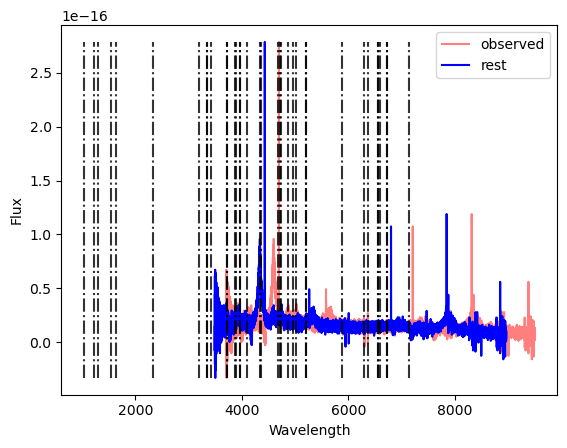

Has a redshift of  0.060000000000000005
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/magpi2304104201_aperture_1.25R50_ppxf.fits


/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = sup

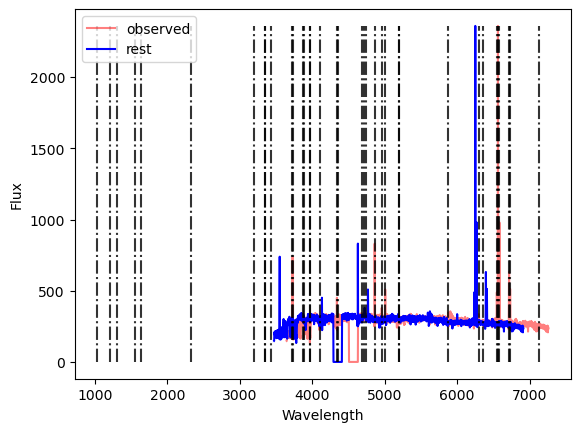

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
huh
SNR is  None
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_013700.03-333858.58_LJ1.fits


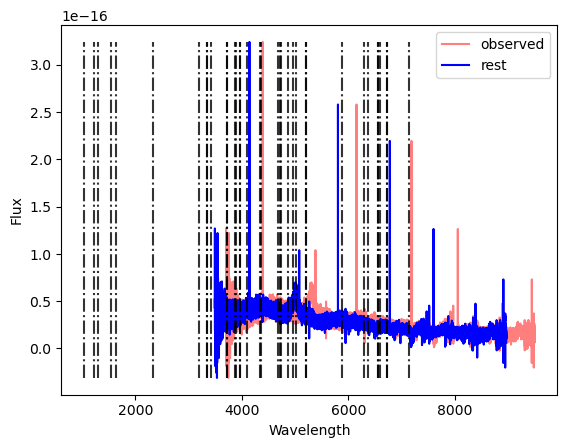

Has a redshift of  0.060000000000000005
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_011708.49-191258.11_LJ1.fits


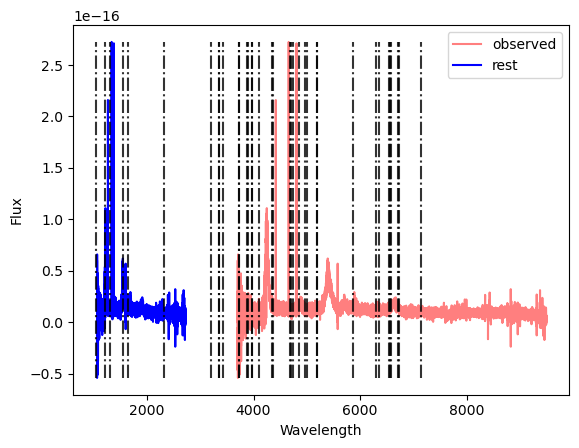

Has a redshift of  2.4900000000000007
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_000351.38-153220.14_LJ1.fits


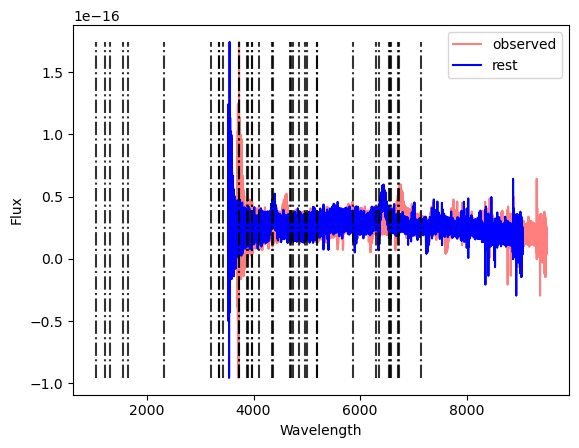

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_000153.90-215901.05_LJ1.fits


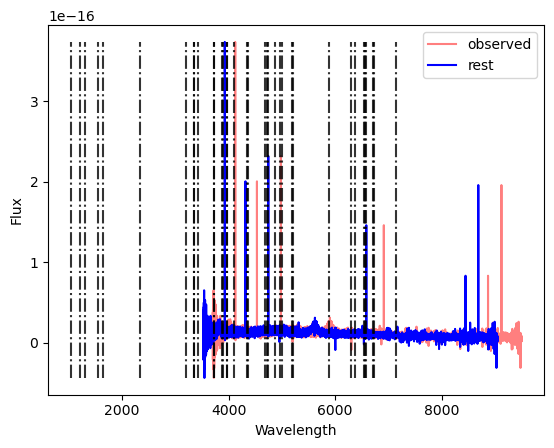

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_021149.04-260810.71_LJ1.fits


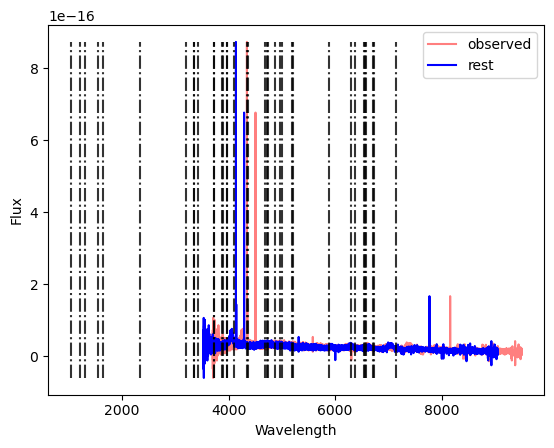

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_002742.94-293946.14_LJ1.fits


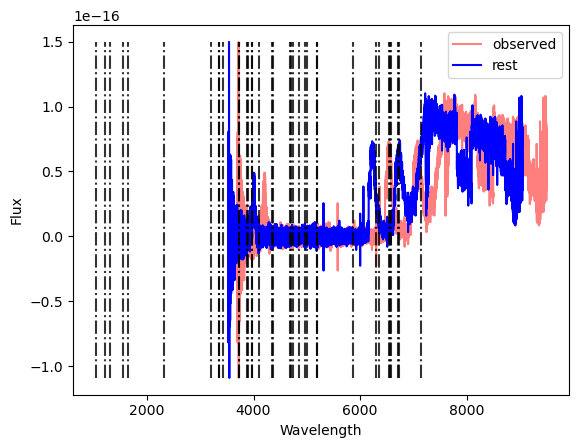

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_014817.88-615640.60_LJ1.fits


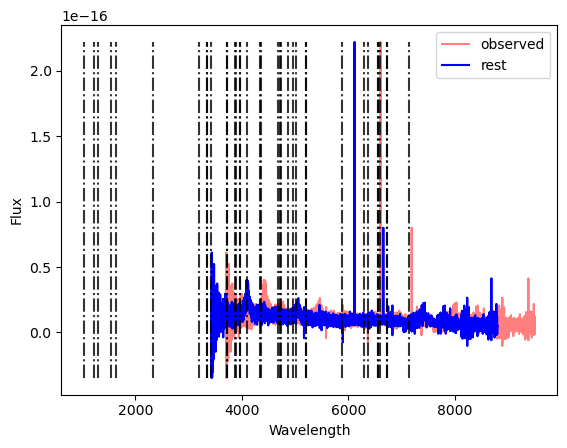

Has a redshift of  0.08000000000000002
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_023018.71-551419.94_LJ1.fits


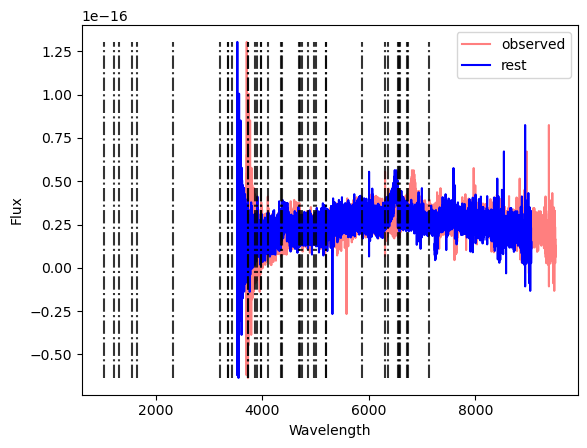

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_005214.83-513256.07_LJ1.fits


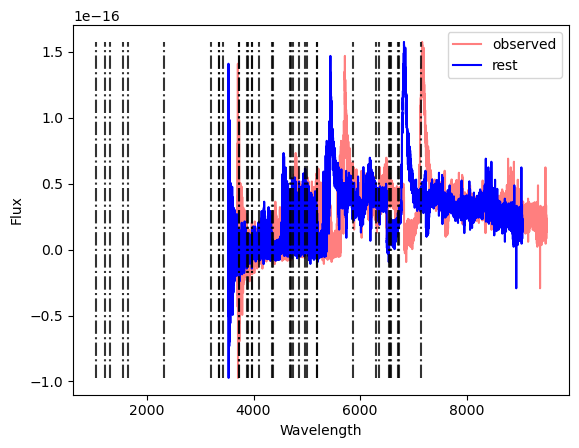

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_003936.39-363904.01_LJ1.fits


Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_030347.63-233455.49_LJ1.fits


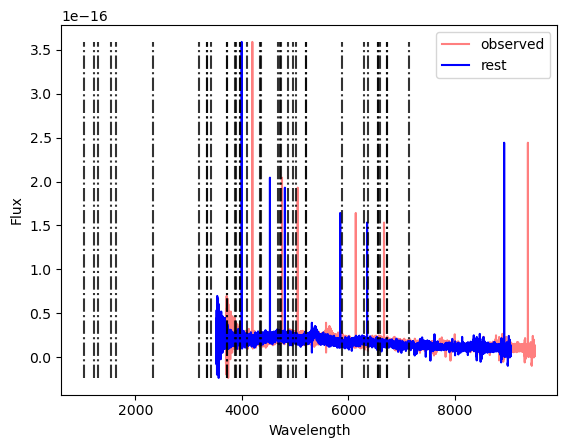

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_022444.84-625501.78_LJ1.fits


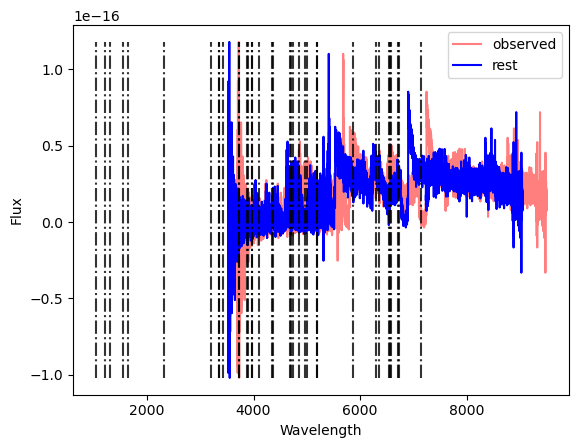

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-7815-6104-0.5Reff-DAP.fits


Has a redshift of  0.08000000000000002
SNR is  -1.2842317858009236
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_012718.76-292642.57_LJ1.fits


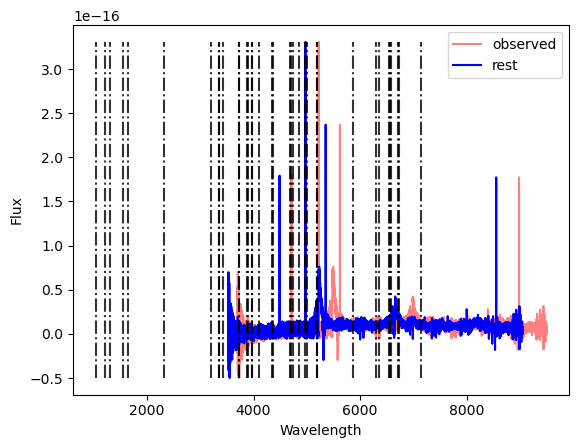

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_023852.89-552941.58_LJ1.fits


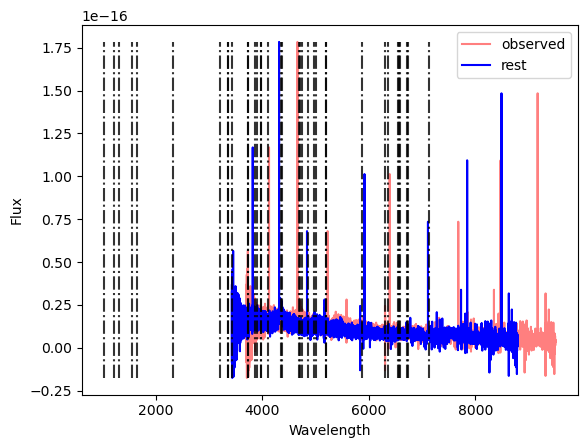

Has a redshift of  0.08000000000000002
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_002140.16-415827.99_LJ1.fits


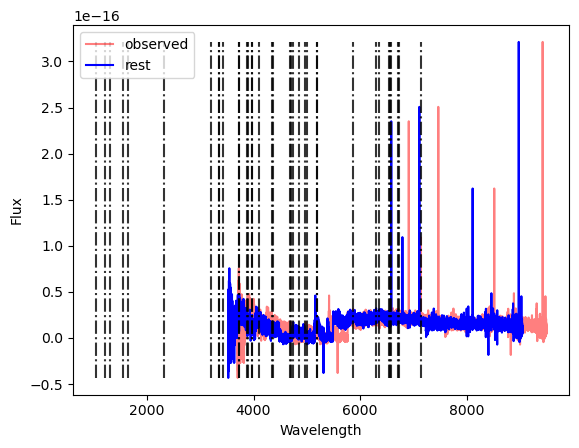

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_024537.77-211635.19_LJ1.fits


Has a redshift of  0.07
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_000537.14-192913.35_LJ1.fits


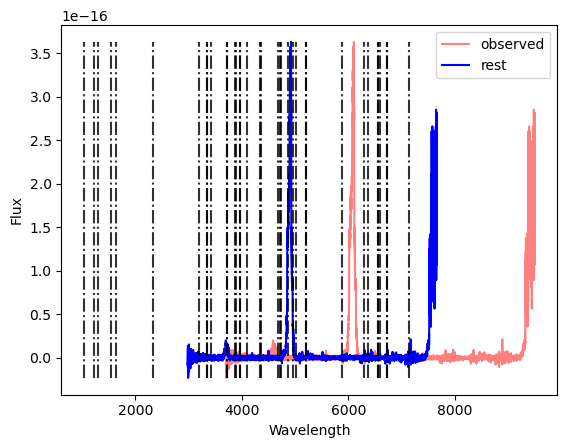

Has a redshift of  0.24000000000000005
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_000047.09-302857.50_LJ1.fits


Has a redshift of  2.1400000000000006
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_022233.90-513102.95_LJ1.fits


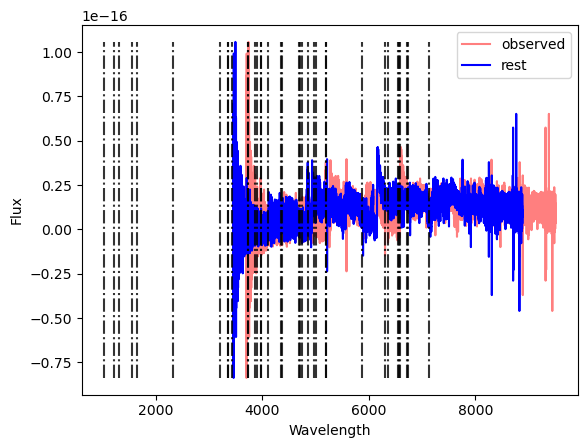

Has a redshift of  0.07
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_024533.09-490220.28_LJ1.fits


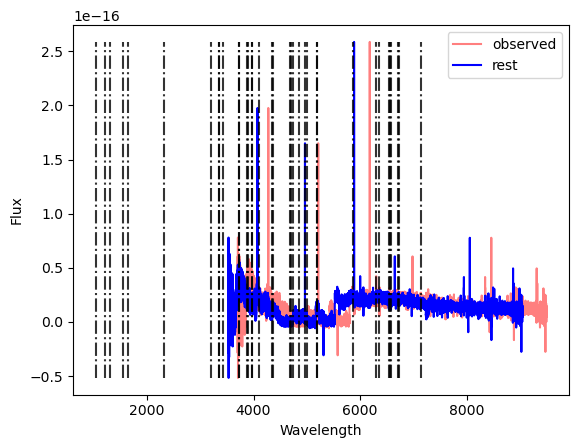

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_021915.28-600523.07_LJ1.fits


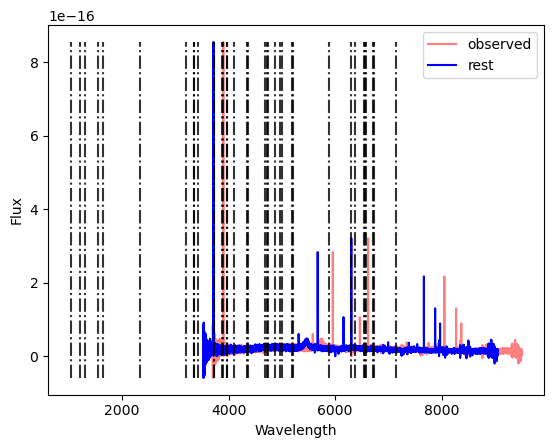

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_014243.22-302233.55_LJ1.fits


Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_002021.46-665821.09_LJ1.fits


Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_020745.73-470008.79_LJ1.fits


Has a redshift of  0.060000000000000005
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_014708.79-412307.52_LJ1.fits


Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_020758.99-385951.03_LJ1.fits


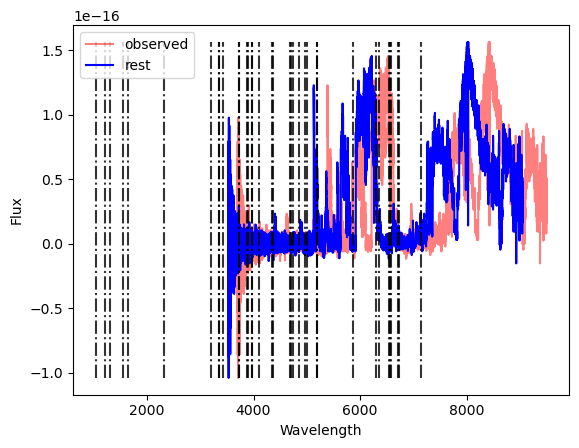

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_003215.86-354217.00_LJ1.fits


Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_025041.57-195009.73_LJ1.fits


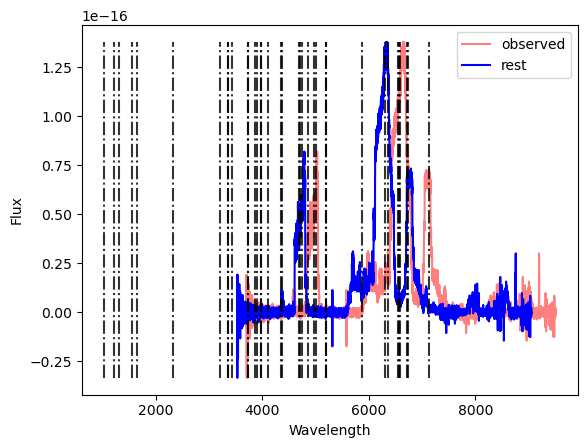

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_000648.35-294017.52_LJ1.fits


Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_030604.29-344406.70_LJ1.fits


Has a redshift of  0.08000000000000002
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_004527.50-203625.10_LJ1.fits


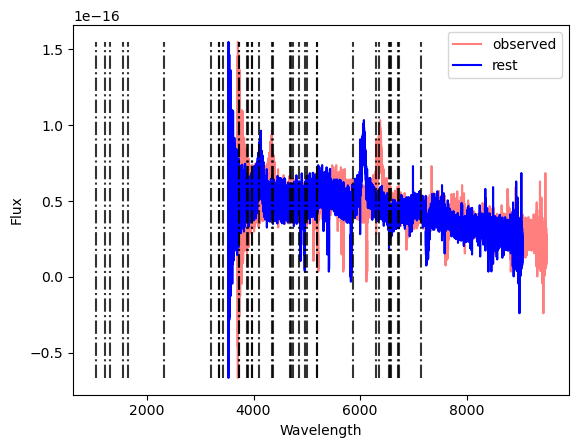

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-8089-12705_Reff_spec.fits


Has a redshift of  0.060000000000000005
SNR is  1.83293750818969
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_024205.49-202955.55_LJ1.fits


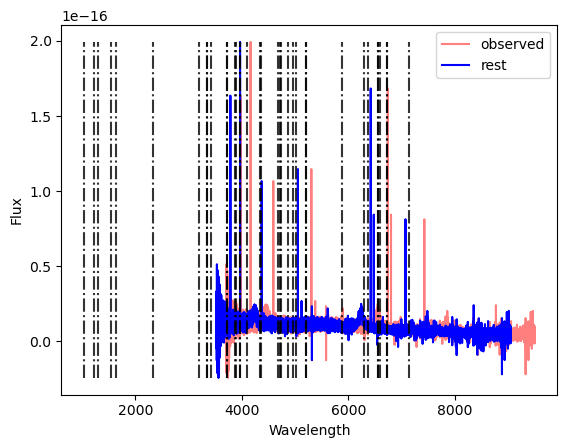

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-7815-6104_Reff_spec.fits


Has a redshift of  0.08000000000000002
SNR is  -1.559271710061084
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-8553-1901-0.5Reff.fits


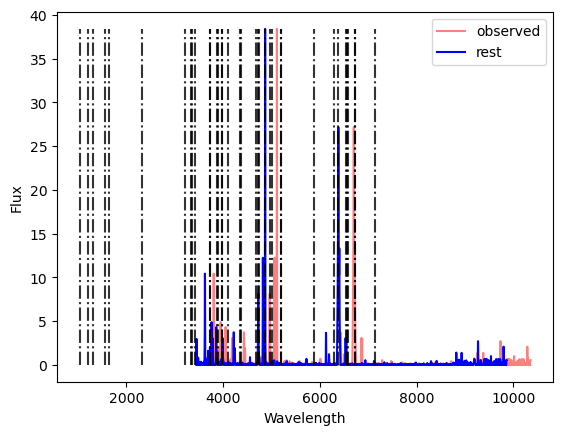

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-8550-3704-0.5Reff.fits


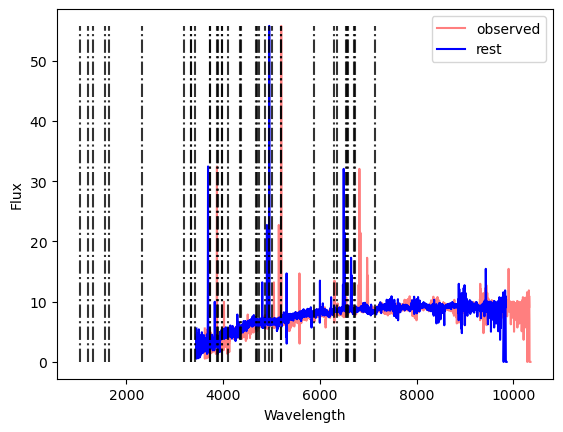

Has a redshift of  0.05
SNR is  2.491718870008413
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-7815-6104-0.5Reff.fits


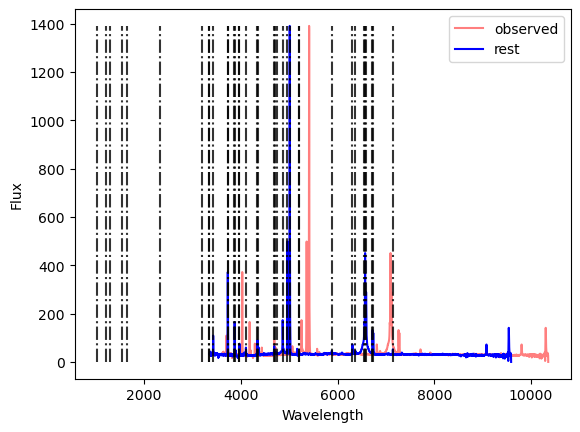

Has a redshift of  0.08000000000000002
SNR is  -1.2842317858009236
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-9000-1901-0.5Reff.fits


Has a redshift of  0.05
SNR is  8.821074510153439
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-7958-9101_Reff_spec.fits


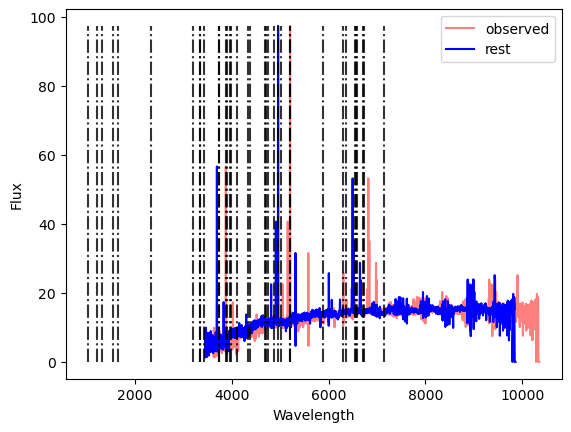

Has a redshift of  0.05
SNR is  1.4741603932950567
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-7992-9102_Reff_spec.fits


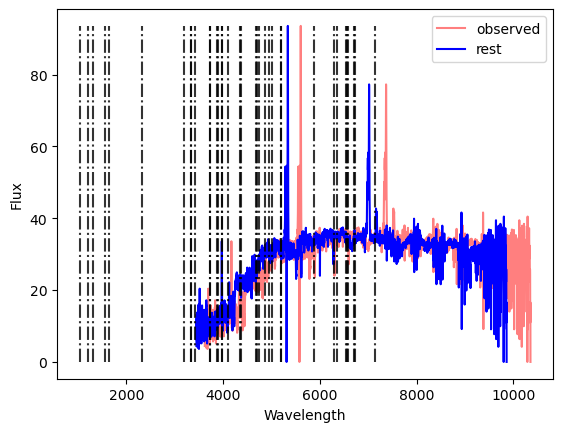

Has a redshift of  0.05
SNR is  4.07258788553025
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-9028-6102-0.5Reff.fits


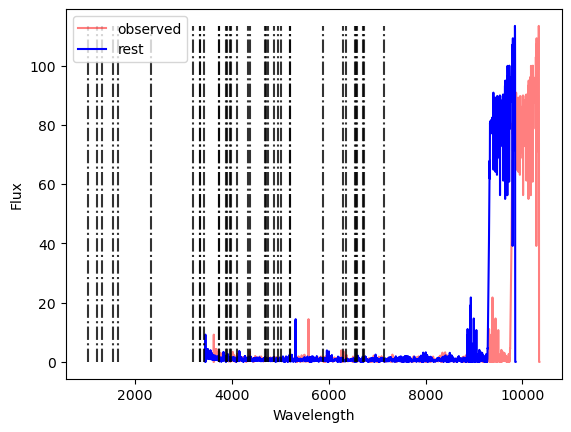

Has a redshift of  0.05
SNR is  8.755626506346902
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-7978-12705_Reff_spec.fits


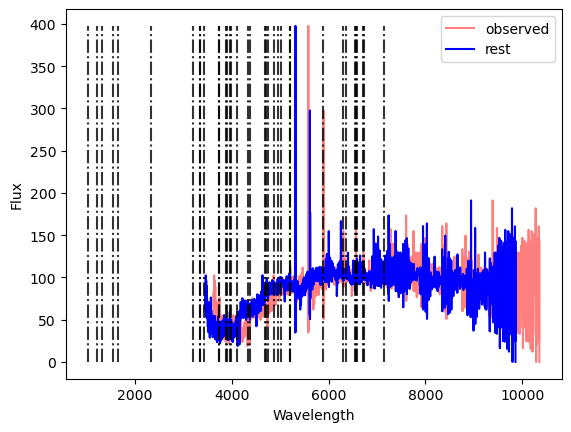

Has a redshift of  0.05
SNR is  39.17164842038863
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-8550-3704-0.5Reff-DAP.fits


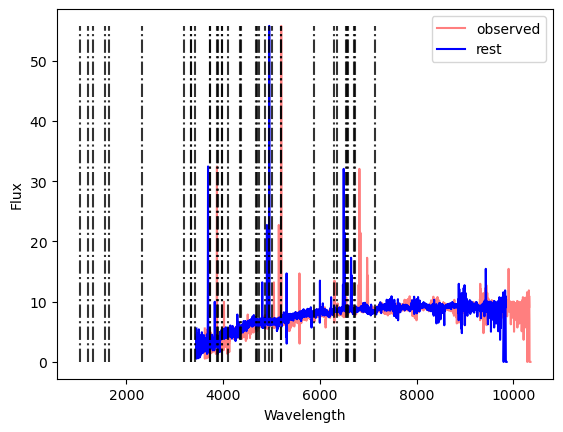

Has a redshift of  0.05
SNR is  2.491718870008413


In [87]:
import os

directory = '/Users/aksitadeo/PycharmProjects/spelfig_aksita/input'

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".fits"): # filename.startswith("manga") and
        print(os.path.join(directory, filename))
        full_dir = os.path.join(directory, filename)

        # id
        spec_dict['ID'].append(filename)                                        # to be edited by JL

        # spectra
        data = extract_astronomical_data(full_dir)
        spec_dict['SPECTRA'].append(data)

        redshift
        redshift = redshift_templ(data,Plot=True)
        print("Has a redshift of ", redshift)
        spec_dict['REDSHIFT'].append(redshift)

        # snr
        try:
          snr = extract_snr(data, redshift, line='O-III,0')
          spec_dict['SNR'].append(snr)
        except:
          print('UnboundLocalError')
          spec_dict['SNR'].append(0)

        continue
    else:
        continue

In [88]:
spec_dict

{'ID': ['PAQS_000439.86-271539.36_LJ1.fits',
  'magpi2304104201_aperture_1.25R50_ppxf.fits',
  'PAQS_013700.03-333858.58_LJ1.fits',
  'PAQS_011708.49-191258.11_LJ1.fits',
  'PAQS_000351.38-153220.14_LJ1.fits',
  'PAQS_000153.90-215901.05_LJ1.fits',
  'PAQS_021149.04-260810.71_LJ1.fits',
  'PAQS_002742.94-293946.14_LJ1.fits',
  'PAQS_014817.88-615640.60_LJ1.fits',
  'PAQS_023018.71-551419.94_LJ1.fits',
  'PAQS_005214.83-513256.07_LJ1.fits',
  'PAQS_003936.39-363904.01_LJ1.fits',
  'PAQS_030347.63-233455.49_LJ1.fits',
  'PAQS_022444.84-625501.78_LJ1.fits',
  'manga-7815-6104-0.5Reff-DAP.fits',
  'PAQS_012718.76-292642.57_LJ1.fits',
  'PAQS_023852.89-552941.58_LJ1.fits',
  'PAQS_002140.16-415827.99_LJ1.fits',
  'PAQS_024537.77-211635.19_LJ1.fits',
  'PAQS_000537.14-192913.35_LJ1.fits',
  'PAQS_000047.09-302857.50_LJ1.fits',
  'PAQS_022233.90-513102.95_LJ1.fits',
  'PAQS_024533.09-490220.28_LJ1.fits',
  'PAQS_021915.28-600523.07_LJ1.fits',
  'PAQS_014243.22-302233.55_LJ1.fits',
  'PAQS_002

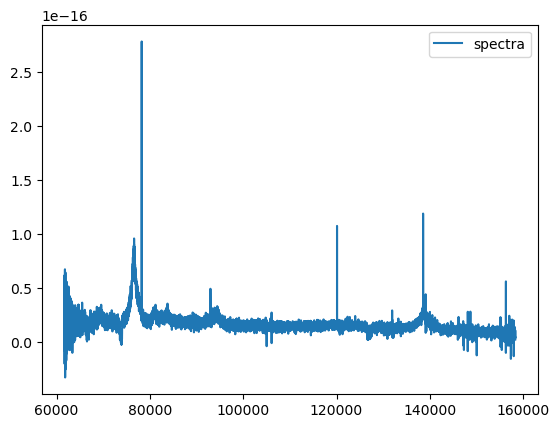

In [91]:
plt.plot(spec_dict['SPECTRA'][0].T[0]/(spec_dict['REDSHIFT'][0]), spec_dict['SPECTRA'][0].T[1], label = 'spectra');
# plt.plot(spec_dict['SPECTRA'][-2].T[0], spec_dict['SPECTRA'][-2].T[2]-100,label = 'errors');
plt.legend()

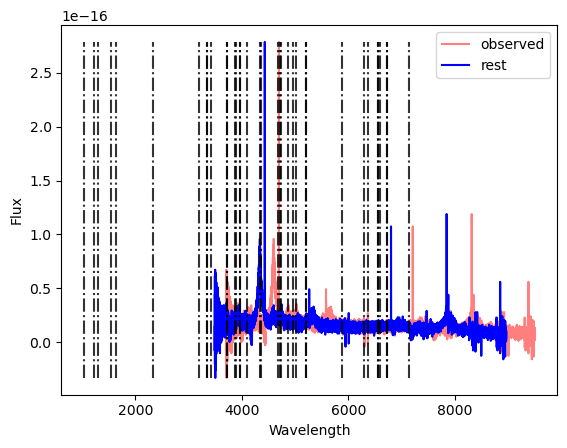

0.060000000000000005

In [83]:
redshift_templ(spec_dict['SPECTRA'][0],Plot=True)

In [ ]:
redshift_templ(spec_dict['SPECTRA'][0], Plot=True)

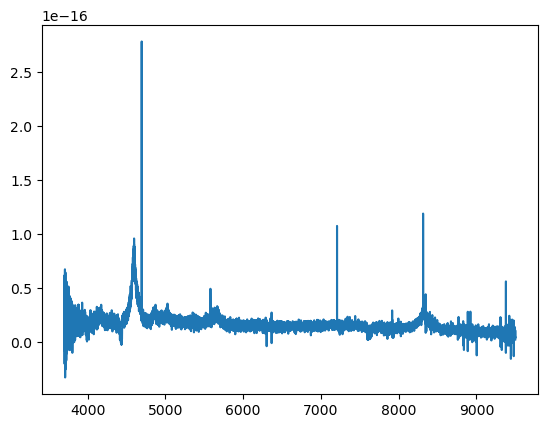

In [92]:
plt.plot(spec_dict['SPECTRA'][0].T[0],spec_dict['SPECTRA'][0].T[1])

### Script

In [335]:
import create_dicts_templatev2 as dict 

In [336]:
templ = dict.initialise_templates('/Users/aksitadeo/PycharmProjects/spelfig_aksita/template/')

spec: Spectrum1D (length=2081)
Flux=[5.2877675e-14 5.4940424e-14 3.6574954e-14 ... 1.9050328e-14
      1.7860320e-14 1.5843080e-14] Jy,  mean=0.00000 Jy
Spectral Axis=[ 800.   802.5  805.  ... 5995.  5997.5 6000. ] Angstrom,  mean=3400.00000 Angstrom
spec: Spectrum1D (length=20001)
Flux=[1.27362e-13 1.27332e-13 1.27301e-13 ... 1.66238e-13 1.66242e-13
      1.66246e-13] Jy,  mean=0.00000 Jy
Spectral Axis=[ 1000.   1000.5  1001.  ... 10999.  10999.5 11000. ] Angstrom,  mean=6000.00000 Angstrom
spec: Spectrum1D (length=1264)
Flux=[1.7365755e-15 1.4508134e-15 1.1892954e-15 ... 4.8507524e-14
      4.8007039e-14 4.8658062e-14] Jy,  mean=0.00000 Jy
Spectral Axis=[1235. 1240. 1245. ... 7540. 7545. 7550.] Angstrom,  mean=4392.50000 Angstrom
spec: Spectrum1D (length=2974)
Flux=[4.9919129e-13 3.7751470e-13 3.0653344e-13 ... 2.2040656e-14
      2.2940271e-14 7.4133772e-15] Jy,  mean=0.00000 Jy
Spectral Axis=[1132. 1134. 1136. ... 7074. 7076. 7078.] Angstrom,  mean=4105.00000 Angstrom
spec: Spectru

<WCSAxes: ylabel='Data [Jy]'>

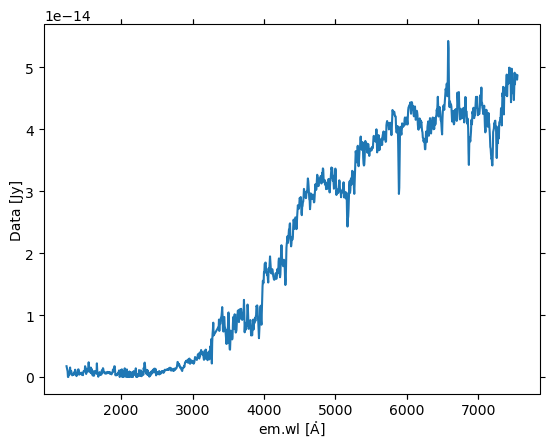

In [337]:
templ[2].plot()

In [338]:
spectra_dictionary = dict.spectrum_dictionary('/Users/aksitadeo/PycharmProjects/spelfig_aksita/input',templ)

Now analysing  /Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_000439.86-271539.36_LJ1.fits


KeyboardInterrupt: 

#### Advanced Script

In [88]:
spectra_dictionary['DATA'][0]

array([[ 3.7002500e+03, -6.6723697e-18,  3.2999808e-17],
       [ 3.7005000e+03,  3.0350574e-17,  3.2996516e-17],
       [ 3.7007500e+03,  2.8242464e-17,  3.2942312e-17],
       ...,
       [ 9.4990000e+03,  9.9946141e-18,  3.5950887e-18],
       [ 9.4992500e+03,  9.0896173e-18,  3.4667787e-18],
       [ 9.4995000e+03,  2.3033984e-18,  3.1702202e-18]], dtype=float32)

In [110]:
import spl_exsetupv37 as spes

idx = 2
spes.extract_snr(spectra_dictionary['DATA'][idx],spectra_dictionary ['REDSHIFT'][idx])

WAVELENGTH  4363.15
FLUX  0
CONT  2.3886445e-18
WAVELENGTH  3202.15
FLUX  0
WAVELENGTH  4685.74
FLUX  0
WAVELENGTH  3345.81
FLUX  0
WAVELENGTH  3425.81
FLUX  0
WAVELENGTH  3726.03
FLUX  0
WAVELENGTH  3728.73
FLUX  0
WAVELENGTH  3868.69
FLUX  0
WAVELENGTH  3967.4
FLUX  0
WAVELENGTH  3889.05
FLUX  0
WAVELENGTH  3970.07
FLUX  0
WAVELENGTH  4101.73
FLUX  0
WAVELENGTH  4340.46
FLUX  0
WAVELENGTH  4363.15
FLUX  0
WAVELENGTH  4958.83
FLUX  0
WAVELENGTH  5006.77
FLUX  0
WAVELENGTH  4711.3
FLUX  0
WAVELENGTH  4740.1
FLUX  0
WAVELENGTH  4861.32
FLUX  0
WAVELENGTH  5197.9
FLUX  0
WAVELENGTH  5200.39
FLUX  0
WAVELENGTH  5875.6
FLUX  0
WAVELENGTH  6300.2
FLUX  0
WAVELENGTH  6363.67
FLUX  0
WAVELENGTH  6547.96
FLUX  0
WAVELENGTH  6583.34
FLUX  0
WAVELENGTH  6562.8
FLUX  0
WAVELENGTH  6716.31
FLUX  0
WAVELENGTH  6730.68
FLUX  0
WAVELENGTH  7135.67
FLUX  0


(-16.408956073600596, [])

#### PAQS Redshift Keyword

In [118]:
spectra_dictionary

{'FILENAME': ['PAQS_000439.86-271539.36_LJ1.fits',
  'magpi2304104201_aperture_1.25R50_ppxf.fits',
  'PAQS_013700.03-333858.58_LJ1.fits',
  'PAQS_011708.49-191258.11_LJ1.fits',
  'PAQS_000351.38-153220.14_LJ1.fits',
  'PAQS_000153.90-215901.05_LJ1.fits',
  'PAQS_021149.04-260810.71_LJ1.fits',
  'PAQS_002742.94-293946.14_LJ1.fits',
  'PAQS_014817.88-615640.60_LJ1.fits',
  'PAQS_023018.71-551419.94_LJ1.fits',
  'PAQS_005214.83-513256.07_LJ1.fits',
  'PAQS_003936.39-363904.01_LJ1.fits',
  'PAQS_030347.63-233455.49_LJ1.fits',
  'PAQS_022444.84-625501.78_LJ1.fits',
  'manga-7815-6104-0.5Reff-DAP.fits',
  'PAQS_012718.76-292642.57_LJ1.fits',
  'PAQS_023852.89-552941.58_LJ1.fits',
  'PAQS_002140.16-415827.99_LJ1.fits',
  'PAQS_024537.77-211635.19_LJ1.fits',
  'PAQS_000537.14-192913.35_LJ1.fits',
  'PAQS_000047.09-302857.50_LJ1.fits',
  'PAQS_022233.90-513102.95_LJ1.fits',
  'PAQS_024533.09-490220.28_LJ1.fits',
  'PAQS_021915.28-600523.07_LJ1.fits',
  'PAQS_014243.22-302233.55_LJ1.fits',
  'PA

In [ ]:
spes.redshift_calc()

In [340]:
import spl_execsetupv3 as spes

spes.redshift_calcu(spectra_dictionary['DATA'][19], templ, spectra_dictionary['FILENAME'][0],Plot=True)

NameError: name 'spectra_dictionary' is not defined

In [186]:
spectra_dictionary['DATA'][3][:,0]

array([3700.25, 3700.5 , 3700.75, ..., 9499.  , 9499.25, 9499.5 ],
      dtype=float32)

In [ ]:
PAQS_000537.14-192913.35_LJ1.fits

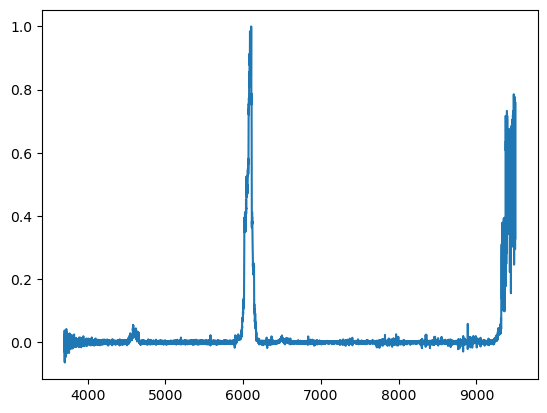

In [242]:
plt.plot(spectra_dictionary['DATA'][19][:,0],spectra_dictionary['DATA'][19][:,1]/max(spectra_dictionary['DATA'][19][:,1]))

In [357]:
import spl_execsetupv3 as spes

redshift_range = np.arange(0.00, 2.49, 0.01)
most_lines_dict = None
max_num_lines = 0
best_redshift = None

for red in redshift_range:
    try:
        snr, identified_lines = spes.extract_redshift_snr(spectra_dictionary['DATA'][-6], red, line=None)
        if identified_lines:
            num_lines = len(identified_lines)
            if num_lines >= max_num_lines:
                most_lines_dict = identified_lines
                max_num_lines = num_lines
                best_redshift = red  # Store the redshift
    except Exception as e:
        continue

print("Line dictionary with the most entries:")
print(most_lines_dict)
print("Best redshift:", best_redshift)

Line dictionary with the most entries:
[{'line': 'O-II,1', 'restframe_wavelength': 3726.03, 'observed_wavelength': 3712.9496402877694, 'peak_flux': 1.0, 'peak_idx': 1026}, {'line': 'O-II,2', 'restframe_wavelength': 3728.73, 'observed_wavelength': 3712.9496402877694, 'peak_flux': 1.0, 'peak_idx': 1026}]
Best redshift: 0.39


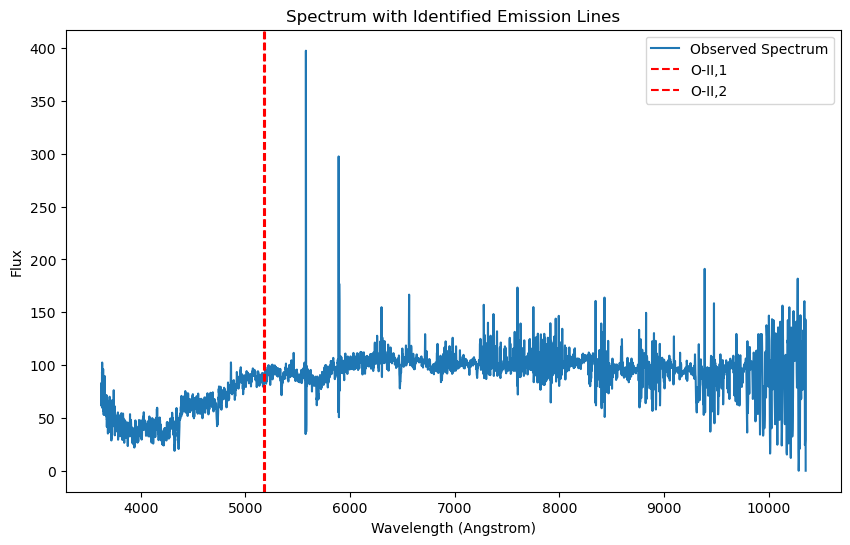

In [358]:
import matplotlib.pyplot as plt

def plot_identified_lines(spectrum, identified_lines, redshift):
    """
    Plots the identified emission lines on the given spectrum.

    Args:
        spectrum (np.ndarray): The spectrum data.
        identified_lines (list): A list of dictionaries containing line information.
        redshift (float): The redshift of the spectrum.

    Returns:
        None
    """

    wavelength = spectrum[:, 0]
    flux = spectrum[:, 1]

    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux, label='Observed Spectrum')

    for line_dict in identified_lines:
        rest_wavelength = line_dict['restframe_wavelength']
        observed_wavelength = rest_wavelength * (1 + redshift)
        plt.axvline(observed_wavelength, color='red', linestyle='--', label=f"{line_dict['line']}")

    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Flux')
    plt.title('Spectrum with Identified Emission Lines')
    plt.legend()
    plt.show()

# Example usage:
spectrum_data = spectra_dictionary['DATA'][-2]  # Replace with your spectrum data
redshift = best_redshift  # Assuming you have the best redshift
identified_lines = most_lines_dict  # Assuming you have the identified lines

plot_identified_lines(spectrum_data, identified_lines, redshift)

In [330]:
snr

0.0

In [319]:
spectrum_data = spectra_dictionary['DATA'][10]

redz = 0.08
linez = [{'line': 'Ne-V,2', 'restframe_wavelength': 3425.81, 'observed_wavelength': 3430.7869, 'peak_flux': 0.8949453, 'peak_idx': 20}]

plot_identified_lines(spectrum_data, linez, redz)

In [252]:
spes.extract_snr(spectra_dictionary['DATA'][19], 0.41, line=None)

(3.961253e-05,
 [{'line': 'S-II,1',
   'restframe_wavelength': 6716.31,
   'observed_wavelength': 6723.4043,
   'peak_flux': 0.78538793,
   'peak_idx': 23119}])

In [247]:
line

(0.022706944, [])

In [333]:
dir = "/Users/aksitadeo/PycharmProjects/spelfig_aksita/input"

for f in os.listdir(dir):
    if f.startswith("PAQS"):
        print(f)

PAQS_000439.86-271539.36_LJ1.fits
PAQS_013700.03-333858.58_LJ1.fits
PAQS_011708.49-191258.11_LJ1.fits
PAQS_000351.38-153220.14_LJ1.fits
PAQS_000153.90-215901.05_LJ1.fits
PAQS_021149.04-260810.71_LJ1.fits
PAQS_002742.94-293946.14_LJ1.fits
PAQS_014817.88-615640.60_LJ1.fits
PAQS_023018.71-551419.94_LJ1.fits
PAQS_005214.83-513256.07_LJ1.fits
PAQS_003936.39-363904.01_LJ1.fits
PAQS_030347.63-233455.49_LJ1.fits
PAQS_022444.84-625501.78_LJ1.fits
PAQS_012718.76-292642.57_LJ1.fits
PAQS_023852.89-552941.58_LJ1.fits
PAQS_002140.16-415827.99_LJ1.fits
PAQS_024537.77-211635.19_LJ1.fits
PAQS_000537.14-192913.35_LJ1.fits
PAQS_000047.09-302857.50_LJ1.fits
PAQS_022233.90-513102.95_LJ1.fits
PAQS_024533.09-490220.28_LJ1.fits
PAQS_021915.28-600523.07_LJ1.fits
PAQS_014243.22-302233.55_LJ1.fits
PAQS_002021.46-665821.09_LJ1.fits
PAQS_020745.73-470008.79_LJ1.fits
PAQS_014708.79-412307.52_LJ1.fits
PAQS_020758.99-385951.03_LJ1.fits
PAQS_003215.86-354217.00_LJ1.fits
PAQS_025041.57-195009.73_LJ1.fits
PAQS_000648.35

In [334]:
spectra_dictionary = dict.spectrum_dictionary('/Users/aksitadeo/PycharmProjects/spelfig_aksita/input',templ)


AttributeError: type object 'dict' has no attribute 'spectrum_dictionary'

### Testing


In [331]:
emission_line_models = {
	'He-II,1': {'wavelength':[3202.15], 'components': ['Lorentzian', 'Lorentzian']},
	'He-II,2': {'wavelength':[4685.74], 'components': ['Lorentzian', 'Lorentzian']},
	'Ne-V,1':  {'wavelength':[3345.81], 'components': ['Lorentzian']},
	'Ne-V,2':  {'wavelength':[3425.81], 'components': ['Lorentzian']},
	'O-II,1':  {'wavelength':[3726.03], 'components': ['Lorentzian']},
	'O-II,2':  {'wavelength':[3728.73], 'components': ['Lorentzian']},
	'Ne-III,1': {'wavelength':[3868.69], 'components': ['Lorentzian']},
	'Ne-III,2': {'wavelength':[3967.40], 'components': ['Lorentzian']},
	'H-ζ':    {'wavelength':[3889.05], 'components': ['Lorentzian', 'Lorentzian']},
	'H-ε':    {'wavelength':[3970.07], 'components': ['Lorentzian', 'Lorentzian']},
	'H-δ':    {'wavelength':[4101.73], 'components': ['Lorentzian', 'Lorentzian']},
	'H-γ':    {'wavelength':[4340.46], 'components': ['Lorentzian', 'Lorentzian']},
	'O-III,0':  {'wavelength':[4363.15], 'components': ['Lorentzian']},
	'O-III,1':  {'wavelength':[4958.83], 'components': ['Lorentzian']},
	'O-III,2':  {'wavelength':[5006.77], 'components': ['Lorentzian']},
	'Ar-IV,1':  {'wavelength':[4711.30], 'components': ['Lorentzian']},
	'Ar-IV,2':  {'wavelength':[4740.10], 'components': ['Lorentzian']},
	'H-β':     {'wavelength':[4861.32], 'components': ['Lorentzian', 'Lorentzian']},
	'N-I,1':    {'wavelength':[5197.90], 'components': ['Lorentzian']},
	'N-I,2':    {'wavelength':[5200.39], 'components': ['Lorentzian']},
	'He-I':   {'wavelength':[5875.60], 'components': ['Lorentzian']},
	'O-I,1':   {'wavelength':[6300.20], 'components': ['Lorentzian']},
	'O-I,2':   {'wavelength':[6363.67], 'components': ['Lorentzian']},
	'N-II,1':   {'wavelength':[6547.96], 'components': ['Lorentzian']},
	'N-II,2':   {'wavelength':[6583.34], 'components': ['Lorentzian']},
	'H-α':     {'wavelength':[6562.80], 'components': ['Lorentzian', 'Lorentzian']},
	'S-II,1':  {'wavelength': [6716.31], 'components': ['Lorentzian']},
	'S-II,2':   {'wavelength':[6730.68], 'components': ['Lorentzian']},
	'Ar-III': {'wavelength':[7135.67], 'components': ['Lorentzian']},
	}

In [344]:
super_dictionary

{'PAQS_000439.86-271539.36_LJ1.fits': {'DATA': array([[ 3.7002500e+03, -6.6723697e-18,  3.2999808e-17],
         [ 3.7005000e+03,  3.0350574e-17,  3.2996516e-17],
         [ 3.7007500e+03,  2.8242464e-17,  3.2942312e-17],
         ...,
         [ 9.4990000e+03,  9.9946141e-18,  3.5950887e-18],
         [ 9.4992500e+03,  9.0896173e-18,  3.4667787e-18],
         [ 9.4995000e+03,  2.3033984e-18,  3.1702202e-18]], dtype=float32),
  'REDSHIFT': 0.26,
  'SNR': 0.00021083055,
  'EMLINES': [{'line': 'O-II,1',
    'restframe_wavelength': 3726.03,
    'observed_wavelength': 3725.7937,
    'peak_flux': 1.0,
    'peak_idx': 3977},
   {'line': 'O-II,2',
    'restframe_wavelength': 3728.73,
    'observed_wavelength': 3725.7937,
    'peak_flux': 1.0,
    'peak_idx': 3977}]},
 'magpi2304104201_aperture_1.25R50_ppxf.fits': {'DATA': array([[3.64826046e+03, 1.47479630e+02, 3.83433637e-01],
         [3.64874819e+03, 1.47696628e+02, 1.11491060e-01],
         [3.64923599e+03, 1.68134353e+02, 0.00000000e+00]

In [343]:
ind = -6

PAQS = super_dictionary['SPECTRUM'][ind]
print(super_dictionary['FILENAME'][ind])
redshPAQS = super_dictionary['REDSHIFT'][ind]

initial_conditions = {
    "powerlaw function": {"gamma": -0.01}
}
gamma0 = -0.01

try:
    dfPAQS = sps.init_setup(PAQS, emission_line_models, specrange, gamma0);
except RuntimeWarning:
    print("Error occurred during setup. Skipping...")
    dfPAQS = np.empty(0)

dfPAQS

KeyError: 'SPECTRUM'

/Users/aksitadeo/PycharmProjects/spelfig_aksita/sps_setupv2.py:329: RuntimeWarning: divide by zero encountered in divide
  residuals = (abs(y - y_evaluated) / y) * 100  # Compute percentage residuals


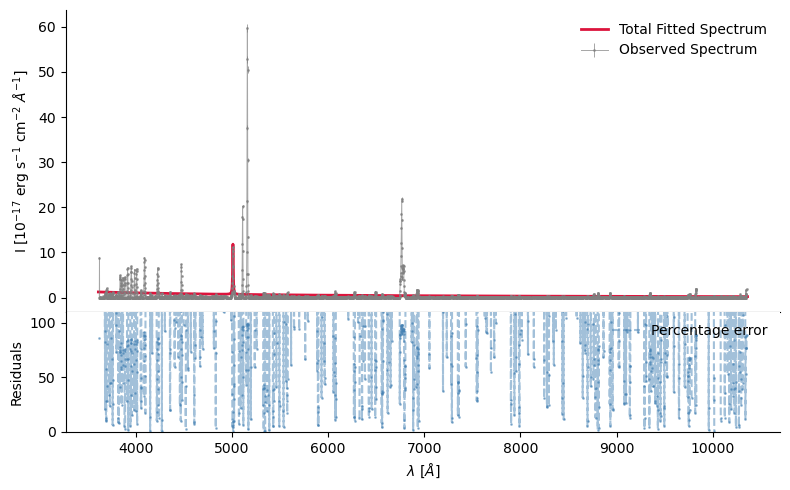

In [279]:
# Lets visualize the initial estimations:
plot0 = sps.spl_plot(PAQS[:, 0], PAQS[:, 1], PAQS[:, 2], dfPAQS)#, x_zoom=(5500, 6800))

In [280]:
fitPAQS = spf.run_mcmc_chains(dfPAQS, PAQS[:, 0], PAQS[:, 1], PAQS[:, 0], niter=5000)
fitPAQS

ndim inside sampler 6
emcee: Exception while calling your likelihood function:
  params: [5.01100213e+03 1.11562227e+01 3.65202917e+00 2.55199365e-01
 8.97888682e+03 1.72274301e+00]
  args: [array([ 3622. ,  3623.5,  3625. , ..., 10348. , 10349.5, 10351. ]), array([0.        , 8.77098411, 0.        , ..., 0.86182812, 0.86182812,
       1.8603479 ]), array([ 3622. ,  3623.5,  3625. , ..., 10348. , 10349.5, 10351. ]), array(['Lorentzian', 'Continuum'], dtype=object), array([5.00441878e+03, 0.00000000e+00, 2.22000000e+00,           -inf,
       0.00000000e+00,           -inf]), array([5017.58122144,   11.15755856,    5.47886685,           inf,
                 inf,           inf]), Line Name
Continuum    0
O-III,2      1
Name: Component, dtype: int64]
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/aksitadeo/PycharmProjects/spelfig_aksita/spl_fitters.py", line 73, in log_posterior
    lp = logpriors(theta, min_values, max_values, components)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/aksitadeo/PycharmProjects/spelfig_aksita/spl_fitters.py", line 58, in logpriors
    if total_amplitude > maxflux:
       ^^^^^^^^^^^^^^^
UnboundLocalError: cannot access local variable 'maxflux' where it is not associated with a value


UnboundLocalError: cannot access local variable 'maxflux' where it is not associated with a value

In [277]:
plotPAQS = sps.spl_plot(PAQS[:, 0]/(1+redshPAQS), PAQS[:, 1], PAQS[:, 2], fitPAQS, x_zoom=(6500, 6800)) #, x_zoom=(4800, 5050))

/Users/aksitadeo/PycharmProjects/spelfig_aksita/sps_setupv2.py:329: RuntimeWarning: divide by zero encountered in divide
  residuals = (abs(y - y_evaluated) / y) * 100  # Compute percentage residuals


## Final Script

In [3]:
import spl_execv1 as spex
import spl_execsetupv3 as spes

In [4]:
templ = spes.initialise_templates('/Users/aksitadeo/PycharmProjects/spelfig_aksita/template/')

spec: Spectrum1D (length=2081)
Flux=[5.2877675e-14 5.4940424e-14 3.6574954e-14 ... 1.9050328e-14
      1.7860320e-14 1.5843080e-14] Jy,  mean=0.00000 Jy
Spectral Axis=[ 800.   802.5  805.  ... 5995.  5997.5 6000. ] Angstrom,  mean=3400.00000 Angstrom
spec: Spectrum1D (length=20001)
Flux=[1.27362e-13 1.27332e-13 1.27301e-13 ... 1.66238e-13 1.66242e-13
      1.66246e-13] Jy,  mean=0.00000 Jy
Spectral Axis=[ 1000.   1000.5  1001.  ... 10999.  10999.5 11000. ] Angstrom,  mean=6000.00000 Angstrom
spec: Spectrum1D (length=1264)
Flux=[1.7365755e-15 1.4508134e-15 1.1892954e-15 ... 4.8507524e-14
      4.8007039e-14 4.8658062e-14] Jy,  mean=0.00000 Jy
Spectral Axis=[1235. 1240. 1245. ... 7540. 7545. 7550.] Angstrom,  mean=4392.50000 Angstrom
spec: Spectrum1D (length=2974)
Flux=[4.9919129e-13 3.7751470e-13 3.0653344e-13 ... 2.2040656e-14
      2.2940271e-14 7.4133772e-15] Jy,  mean=0.00000 Jy
Spectral Axis=[1132. 1134. 1136. ... 7074. 7076. 7078.] Angstrom,  mean=4105.00000 Angstrom
spec: Spectru

In [ ]:
super_dictionary = spex.spectrum_dictionary('/Users/aksitadeo/PycharmProjects/spelfig_aksita/input',templ)

In [707]:
super_dictionary

{'PAQS_000439.86-271539.36_LJ1.fits': {'DATA': array([[ 3.7002500e+03, -6.6723697e-18,  3.2999808e-17],
         [ 3.7005000e+03,  3.0350574e-17,  3.2996516e-17],
         [ 3.7007500e+03,  2.8242464e-17,  3.2942312e-17],
         ...,
         [ 9.4990000e+03,  9.9946141e-18,  3.5950887e-18],
         [ 9.4992500e+03,  9.0896173e-18,  3.4667787e-18],
         [ 9.4995000e+03,  2.3033984e-18,  3.1702202e-18]], dtype=float32),
  'REDSHIFT': 0.26,
  'SNR': 0.00021083055,
  'EMLINES': [{'line': 'O-II,1',
    'restframe_wavelength': 3726.03,
    'observed_wavelength': 3725.7937,
    'peak_flux': 1.0,
    'peak_idx': 3977},
   {'line': 'O-II,2',
    'restframe_wavelength': 3728.73,
    'observed_wavelength': 3725.7937,
    'peak_flux': 1.0,
    'peak_idx': 3977}]},
 'magpi2304104201_aperture_1.25R50_ppxf.fits': {'DATA': array([[3.64826046e+03, 1.47479630e+02, 3.83433637e-01],
         [3.64874819e+03, 1.47696628e+02, 1.11491060e-01],
         [3.64923599e+03, 1.68134353e+02, 0.00000000e+00]

In [49]:
for row_key, row_data in super_dictionary.items():
    print(row_key)

PAQS_000439.86-271539.36_LJ1.fits
magpi2304104201_aperture_1.25R50_ppxf.fits
PAQS_013700.03-333858.58_LJ1.fits
PAQS_011708.49-191258.11_LJ1.fits
PAQS_000351.38-153220.14_LJ1.fits
PAQS_000153.90-215901.05_LJ1.fits
PAQS_021149.04-260810.71_LJ1.fits
PAQS_002742.94-293946.14_LJ1.fits
PAQS_014817.88-615640.60_LJ1.fits
PAQS_023018.71-551419.94_LJ1.fits
PAQS_005214.83-513256.07_LJ1.fits
PAQS_003936.39-363904.01_LJ1.fits
PAQS_030347.63-233455.49_LJ1.fits
PAQS_022444.84-625501.78_LJ1.fits
manga-7815-6104-0.5Reff-DAP.fits
PAQS_012718.76-292642.57_LJ1.fits
PAQS_023852.89-552941.58_LJ1.fits
PAQS_002140.16-415827.99_LJ1.fits
PAQS_024537.77-211635.19_LJ1.fits
PAQS_000537.14-192913.35_LJ1.fits
PAQS_000047.09-302857.50_LJ1.fits
PAQS_022233.90-513102.95_LJ1.fits
PAQS_024533.09-490220.28_LJ1.fits
PAQS_021915.28-600523.07_LJ1.fits
PAQS_014243.22-302233.55_LJ1.fits
PAQS_002021.46-665821.09_LJ1.fits
PAQS_020745.73-470008.79_LJ1.fits
PAQS_014708.79-412307.52_LJ1.fits
PAQS_020758.99-385951.03_LJ1.fits
PAQS_0

In [23]:
emission_line_models = {
	'He-II,1': {'wavelength':[3202.15], 'components': ['Gaussian', 'Gaussian']},
	'He-II,2': {'wavelength':[4685.74], 'components': ['Gaussian', 'Gaussian']},
	'Ne-V,1':  {'wavelength':[3345.81], 'components': ['Gaussian']},
	'Ne-V,2':  {'wavelength':[3425.81], 'components': ['Gaussian']},
	'O-II,1':  {'wavelength':[3726.03], 'components': ['Gaussian']},
	'O-II,2':  {'wavelength':[3728.73], 'components': ['Gaussian']},
	'Ne-III,1': {'wavelength':[3868.69], 'components': ['Gaussian']},
	'Ne-III,2': {'wavelength':[3967.40], 'components': ['Gaussian']},
	'H-ζ':    {'wavelength':[3889.05], 'components': ['Gaussian', 'Gaussian']},
	'H-ε':    {'wavelength':[3970.07], 'components': ['Gaussian', 'Gaussian']},
	'H-δ':    {'wavelength':[4101.73], 'components': ['Gaussian', 'Gaussian']},
	'H-γ':    {'wavelength':[4340.46], 'components': ['Gaussian', 'Gaussian']},
	'O-III,0':  {'wavelength':[4363.15], 'components': ['Gaussian']},
	'O-III,1':  {'wavelength':[4958.83], 'components': ['Gaussian', 'Lorentzian']},
	'O-III,2':  {'wavelength':[5006.77], 'components': ['Gaussian', 'Lorentzian']},
	'Ar-IV,1':  {'wavelength':[4711.30], 'components': ['Gaussian']},
	'Ar-IV,2':  {'wavelength':[4740.10], 'components': ['Gaussian']},
	'H-β':     {'wavelength':[4861.32], 'components': ['Gaussian', 'Gaussian']},
	'N-I,1':    {'wavelength':[5197.90], 'components': ['Gaussian']},
	'N-I,2':    {'wavelength':[5200.39], 'components': ['Gaussian']},
	'He-I':   {'wavelength':[5875.60], 'components': ['Gaussian']},
	'O-I,1':   {'wavelength':[6300.20], 'components': ['Gaussian']},
	'O-I,2':   {'wavelength':[6363.67], 'components': ['Gaussian']},
	'N-II,1':   {'wavelength':[6547.96], 'components': ['Gaussian']},
	'N-II,2':   {'wavelength':[6583.34], 'components': ['Gaussian']},
	'H-α':     {'wavelength':[6562.80], 'components': ['Gaussian', 'Gaussian']},
	'S-II,1':  {'wavelength': [6716.31], 'components': ['Gaussian', 'Lorentzian']},
	'S-II,2':   {'wavelength':[6730.68], 'components': ['Gaussian', 'Lorentzian']},
	'Ar-III': {'wavelength':[7135.67], 'components': ['Gaussian']},
	}


In [320]:
import sps_fittersaksita as spf

In [326]:
paqsfile = super_dictionary['manga-7958-9101_Reff_spec.fits']#['PAQS_000439.86-271539.36_LJ1.fits']

paqsdata = paqsfile['DATA']
paqsredshift = paqsfile['REDSHIFT']
paqsemlines = paqsfile['EMLINES']

paqsrange = [paqsdata[:,0][0],paqsdata[:,0][-1]]

In [327]:
paqsrange

[3621.595947265625, 10353.8056640625]

In [ ]:
## Spectral index for the continuum:
gamma0 = -0.01

## Observed data stored in variables:
try:
    df_test = spf.init_setup(paqsdata, emission_line_models, paqsrange, gamma0)
except RuntimeWarning:
    print("Error occurred during setup. Skipping...")
    df_test = np.empty(0)

In [329]:
df_test

Line Name      Model  Component  \
0  Continuum  Continuum        0.0   

                                                     Parameters  \
0  [253.02470742429873, 6857.715151178038, -0.6159476370602114]   

        Max Limits Min Limits  
0  [inf, inf, inf]  [0, 0, 0]

In [330]:
plt.plot(paqsdata[:,0],paqsdata[:,1])

In [315]:
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit

In [316]:
def mask_spectrum(wavelengths, flux, lines_dict):

    masked_flux = np.copy(flux)  # Create a copy of the original flux
    continuum_mask = np.ones(len(wavelengths), dtype=bool)  # Initialize a mask of all ones

    for line_info in lines_dict:
        start_idx = np.argmin(np.abs(wavelengths - line_info['start']))
        end_idx = np.argmin(np.abs(wavelengths - line_info['end']))

        # Create a mask for the current line
        line_mask = np.zeros_like(wavelengths, dtype=bool)
        line_mask[start_idx:end_idx + 1] = True

        # Update the continuum mask using bitwise AND
        continuum_mask &= ~line_mask

    # Apply the final continuum mask
    masked_flux[continuum_mask] = np.interp(wavelengths[continuum_mask], wavelengths[~continuum_mask], flux[~continuum_mask])

    return masked_flux

In [317]:
def analyze_emission_lines(x, y, lines_dict, window=20.):

    observed_wavelengths = x
    flux = y

    matched_lines = []
    matches = []
    results = []
    synthetic_flux = np.copy(flux)  # This maintains the original 1D flux array structure

    # Ensure the synthetic_flux initialization doesn't start with NaN values
    if np.isnan(synthetic_flux).all():
        synthetic_flux[:] = 0  # Set to zero or some baseline if entirely NaN

    continuum_mask = np.ones(len(flux), dtype=bool)
    for name, params in lines_dict.items():
        rest_wavelength = params['wavelength'][0]
        if rest_wavelength is not None:
            lower_bound = rest_wavelength - window
            upper_bound = rest_wavelength + window
            mask = (observed_wavelengths >= lower_bound) & (observed_wavelengths <= upper_bound)
            window_flux = flux[mask]
            window_wavelengths = observed_wavelengths[mask]

            if not window_wavelengths.size:
                continue

            peaks, _ = find_peaks(window_flux, prominence=0.5)
            closest_peak_idx = None
            min_diff = float('inf')

            for peak_idx in peaks:
                ## This lines were meant to identify the closest peak
                observed_wavelength = window_wavelengths[peak_idx]
                diff = abs(observed_wavelength - rest_wavelength)

                if diff < min_diff:
                    min_diff = diff
                    closest_peak_idx = peak_idx

            if closest_peak_idx is not None:
                peak_flux = window_flux[closest_peak_idx]
                observed_wavelength = window_wavelengths[closest_peak_idx]
                matches.append({
                    'line': name,
                    'restframe_wavelength': rest_wavelength,
                    'observed_wavelength': observed_wavelength,
                    'peak_flux': peak_flux,
                    'peak_idx': np.where(observed_wavelengths == observed_wavelength)[0][0]
                })

                # Update the synthetic flux with a baseline value within the line window
                peak_idx = matches[-1]['peak_idx']  # Access the last line data
                widths, width_heights, left_ips, right_ips = peak_widths(flux, [peak_idx], rel_height=0.5)
                fwhm = np.interp(left_ips + widths, np.arange(len(flux)), observed_wavelengths) - \
                       np.interp(left_ips, np.arange(len(flux)), observed_wavelengths)

                sigma = fwhm[0] / 2.355
                line_start = observed_wavelength - fwhm[0] / 2 - 3 * sigma
                line_end = observed_wavelength + fwhm[0] / 2 + 3 * sigma
                
                matched_lines.append({
                    'line': name,
                    'restframe_wavelength': rest_wavelength,
                    'observed_wavelength': observed_wavelength,
                    'peak_flux': peak_flux,
                    'peak_idx': np.where(observed_wavelengths == observed_wavelength)[0][0],
                    'start': line_start, 
                    'end': line_end})
                
    print(matched_lines)
                
    contflux = mask_spectrum(x, y, matched_lines)
    continuum = np.column_stack((observed_wavelengths, contflux))
    std_cont = np.nanstd(continuum[:,1])
    
    return results, std_cont, continuum

In [318]:
_, snr, contin = analyze_emission_lines(paqsdata[:,0], paqsdata[:,1], emission_line_models, window=20.)

[{'line': 'He-II,2', 'restframe_wavelength': 4685.74, 'observed_wavelength': 4686.8863950903515, 'peak_flux': 327.9849815368653, 'peak_idx': 1874, 'start': 4682.700958748137, 'end': 4691.071831432566}, {'line': 'O-II,1', 'restframe_wavelength': 3726.03, 'observed_wavelength': 3729.1269131240088, 'peak_flux': 738.7624855041503, 'peak_idx': 164, 'start': 3719.825052035482, 'end': 3738.4287742125357}, {'line': 'O-II,2', 'restframe_wavelength': 3728.73, 'observed_wavelength': 3729.1269131240088, 'peak_flux': 738.7624855041503, 'peak_idx': 164, 'start': 3719.825052035482, 'end': 3738.4287742125357}, {'line': 'Ne-III,1', 'restframe_wavelength': 3868.69, 'observed_wavelength': 3869.8035562083487, 'peak_flux': 317.0291986465454, 'peak_idx': 441, 'start': 3801.8176541780367, 'end': 3937.7894582386607}, {'line': 'Ne-III,2', 'restframe_wavelength': 3967.4, 'observed_wavelength': 3964.5802619407928, 'peak_flux': 221.4399268122201, 'peak_idx': 622, 'start': 3962.908414639039, 'end': 3966.2521092425

In [319]:
plt.plot(paqsdata[:,0], paqsdata[:,1],'k')
plt.plot(contin[:,0],contin[:,1],'r')

In [248]:
snr

5.506684519930201

# Further steps: Automatic algorithm of fitting.
Given a set of different AGN spectra, we must figure out a good set of automatic steps to:
* Start from a baseline model for all AGN. Produce a first fitting
* Add components in an automatic way to the emission profiles that require them (problem: they might be different distributions, and profiles in certain cases might be very broadened and extreme).
* Once we got this cycled solved, transform all of this into an automatic set of scripts, instead of notebook.
* Upload the resultant code to a GitHub.